In [34]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


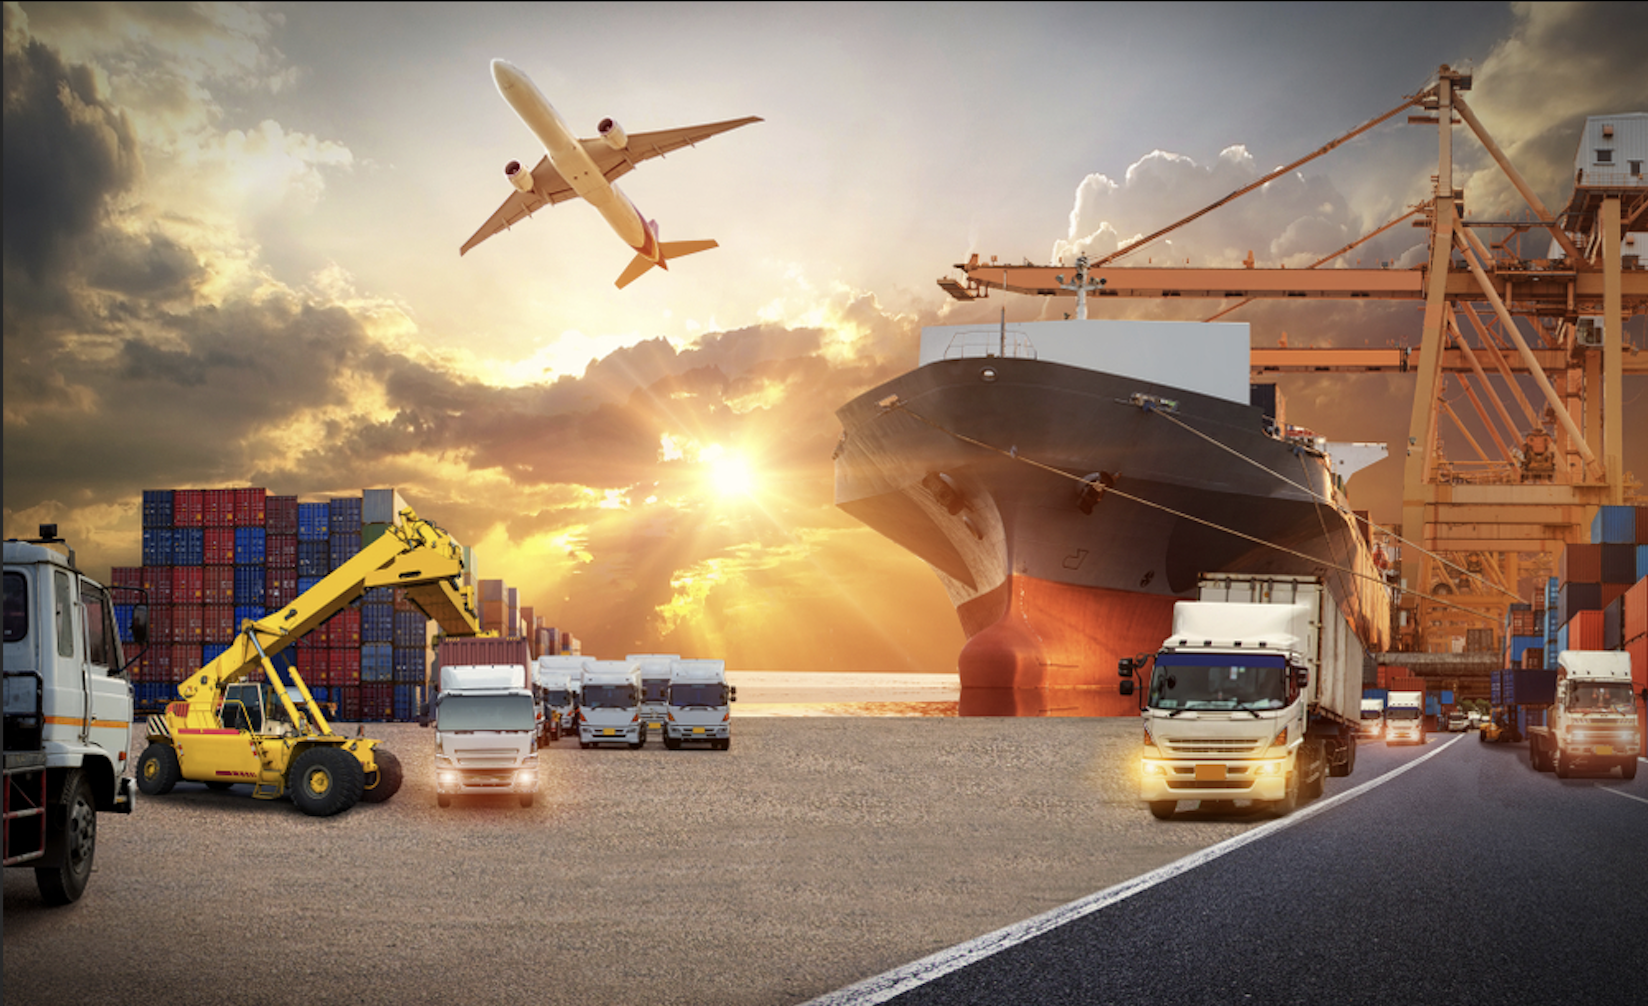

# <font color=li_blue> Table of contents </font>

# <font color=purple> Sections </font>

* [1.Business Problem](#1)
* [2.Libaries used](#2)
* [3. Setup](#3)
  * [3.1 Start MariaDB](#3.1)
  * [3.2 Start Hadoop](#3.2)  
  * [3.3 Search for Spark Installation](#3.3)
  * [3.4 Create SparkSession](#3.4)
  * [3.5 Data Preparation](#3.5)
      * [3.5.1 Raw DataFrame](#3.5.1)
      * [3.5.2 DataFrame Vertices](#3.5.2)
      * [3.5.3 Countries Dataframe Vertices](#3.5.3)
      * [3.5.4 Countries Flows Dataframe](#3.5.4)
          * [3.5.4.1 Detailed Graph](#3.5.4.1)
      * [3.5.5 Country Aggregated Graph](#3.5.5)
      * [3.5.6 Sources Graph](#3.5.6)
      * [3.5.7 Destinations Graph](#3.5.7)
      * [3.5.8 Intercompany Graph](#3.5.8)
      * [3.5.9 Trips Graph](#3.5.9)
* [4. Country Overview](#4)
  * [4.1 Country Map Overview](#4.1)
  * [4.2 Country Overview](#4.2)
      * [4.2.1 What are the most poluting countries](#4.2.1)
      * [4.2.2 What flow types are affecting each country the most](#4.2.2)
* [5. Analysis on Sources, Destinations and Intercompany Trading](#5)      
  * [5.1 Sources: What Third Party Sources are produccing more emissions? ](#5.1)
  * [5.2 Destinations: Where are the higher emission supplying customers? ](#5.2)
  * [5.3 Intercompany:Analyzing business among factories->Nodes with bidirectional ](#5.3)  
* [6. Analysis on the most common routes](#6)   
  * [6.1 Which are the top 5 most popular routes of the country of interest? ](#6.1)  
  * [6.2 Which are the Hubs where most of the trips/routes depart from? ](#6.2)  
  * [6.3 Which are the Hubs where the lowest trips/routes depart from? ](#6.3)   
  * [6.4 Which are the Hubs where most of the trips get to? ](#6.4) 
* [7. Optimizations](#7)   
  * [7.1 Breath-first search (BFS)](#7.1)  
      * [7.1.1 What is the shortest Hub? ](#7.1.1) 
  * [7.2 Connected & Strongly connected component](#7.2)
  * [7.3 Label Propagation](#7.3)
  * [7.4 Shortest path](#7.4)
  * [7.5 All Pair Shortest Path](#7.5)  
  * [7.6 PageRank](#7.6)
* [8. Store the results in MariaDB](#8)
  * [8.1 Countries)](#8.1)  
  * [8.2 Flows)](#8.2)   
  * [8.3 Trading Companies)](#8.3)   
  * [8.4 Sources)](#8.4)     
  * [8.5 Targets](#8.5)
  * [8.6 Outdegree](#8.6)  
  * [8.7 Indegree](#8.7)  
  * [8.8 Communities](#8.8)    
  * [8.9 Intercompany](#8.9)   
  * [8.10 Strong Connected ](#8.10)  
  * [8.11 PageRanke](#8.11)  
* [9. Clustering](#9)
    * [9.1 Problem Statement](#9.1)
    * [9.2 Data Preparation](#9.1)
      * [9.2.1 Exploratorive Analysis](#9.2.1)
      * [9.2.2 Data Cleansing](#9.2.2)
      * [9.2.3 Feature Engineering](#9.2.3)
      * [9.2.4 Transformation](#9.2.4)
      * [9.2.5 Model Evaluation](#9.2.5)
      * [9.2.6. Model Selection](#9.2.6)
      * [9.2.7. Pipeline Architecture](#9.2.7)
      * [9.2.8. KMeans clusters](#9.2.8)
* [10. Finish](#10)
  * [10.1 Stop MariaDB](#10.1)
  * [10.2 Stop Hadoop](#10.2)  

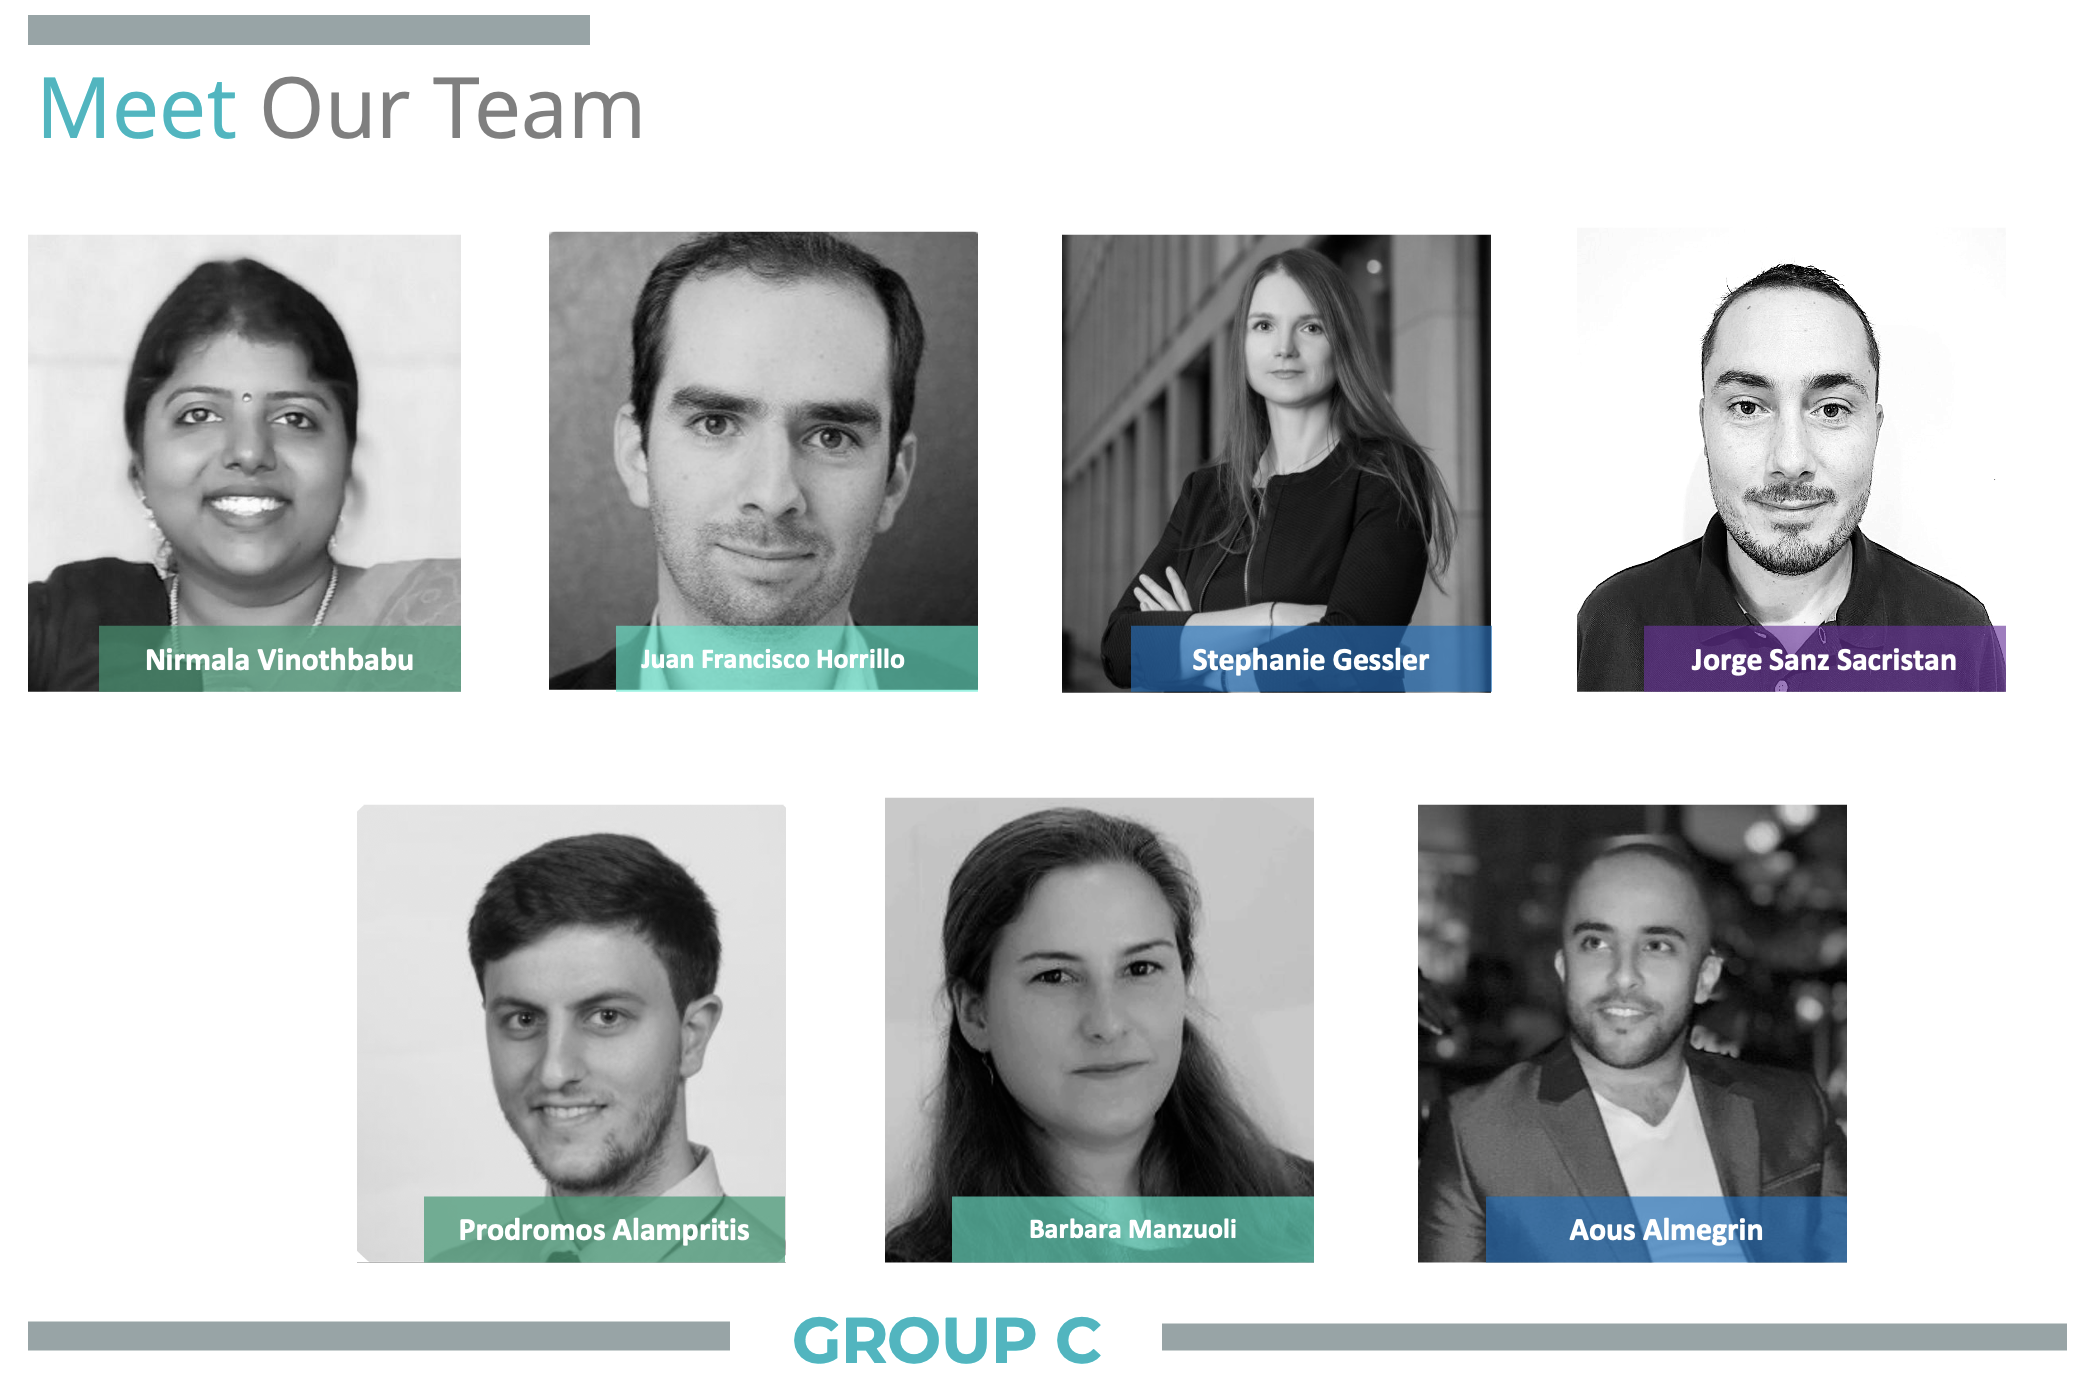

<a id='1'></a>
# <font color=li_blue> 1. Business Problem </font>
</div>
<div class="alert alert-info" role="alert">
    
Goal: Find a way to <a href="#" class="alert-link">quantify C02 emissions</a> related to transportation, help to visualize the current situation and identify the main areas of improvement, so first action plans can be designed.
    

_Sites_: Which of the Sites generate more C02. (Inbound and Outbound). So transportation strategy can be improved.
    

    
_Sources_: What Raw material supplying countries are making to incur into higher emissions. More sustainable suppliers could be evaluated.
    

_Destination_: What final destinations we are emitting more C02. Supply chain can be checked (Maybe a shorter route/new 
factory).    
</div>

<a id='2'></a>
#  <font color=li_blue> 2.Libraries used </font>

In [35]:
import requests
import json

import numpy as np
import pandas as pd
#import pyodbc
#import networkx as nx
import matplotlib.pyplot as plt


<a id='3'></a>
#  <font color=li_blue> 3.Setup </font>

<a id='3.1'></a>
### <font color=li_blue>  3.1 Start MariaDB </font>

</div>
<div class="alert alert-info" role="alert">
  Start MariaDB 
    
 Open a terminal and execute
    
```sh
    
sudo service mariadb start   
    
</div>

Since we are going to process data stored from HDFS let's start the service
<a id='3.2'></a>
### <font color=li_blue> 3.2 Start Hadoop </font>

</div>
<div class="alert alert-info" role="alert">
Start Hadoop

Open a terminal and execute
```sh

hadoop-start.sh

    
</div>

*Download templete with right fields
*Cleansing of missing origin or target
*Enrichment of Regions (including all destinations)

<a id='3.3'></a>
### <font color=li_blue> 3.3 Search for Spark Installation </font>
This step is required just because we are working in the course environment.

In [36]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
print ("Scope 3 Emission Analysis")
print ("--")
print ("Analysis initialization:")
print ("  1. Building the Spark Session...")

Scope 3 Emission Analysis
--
Analysis initialization:
  1. Building the Spark Session...


In [37]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar,/usr/share/java/mariadb-java-client.jar pyspark-shell'

#import os

#os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/share/java/mariadb-java-client.jar pyspark-shell'

<a id='3.4'></a>
### <font color=li_blue> 3.4 Create SparkSession </font>

In [38]:
# 1. Building the Spark Session
sc = SparkSession.builder\
    .master('local')\
    .appName('Scope3')\
    .getOrCreate()
spark = SparkSession(sc)

<a id='3.5'></a>
### <font color=li_blue> 3.5 Data Preparation</font>
### <font color=li_blue> 3.5.1 Raw DataFrame</font>

In [39]:
# 2. Dataframes creation
print ("  2. Creating the vertices (hubs) and edges (trips/routes) DataFrames from HDFS...")
c02= (spark.read
        .option("header","true")
        .option("inferSchema","true")
        .csv("hdfs://localhost:9000/datalake/raw/scope3",sep=",")
        #.limit(20000)
        .distinct())
print(f"There are {c02.count()} rows in the datasets")

  2. Creating the vertices (hubs) and edges (trips/routes) DataFrames from HDFS...


There are 90643 rows in the datasets


Checking the dataframe and the column names with the respective types 

In [40]:
# Using pandas to see the entire table
pd.set_option('display.max_columns', 500)
c02.limit(10).toPandas()

_c0 Origin_Key Origin_Postal_Code Origin_City Origin_Country  \
0    1  014 01-SK             014 01       Bytča             SK   
1  196   01740-FI              01740      Vantaa             FI   
2  373   01740-FI              01740      Vantaa             FI   
3  379   01740-FI              01740      Vantaa             FI   
4  380   01740-FI              01740      Vantaa             FI   
5  473   01740-FI              01740      Vantaa             FI   
6  593   01740-FI              01740      Vantaa             FI   
7  782   01740-FI              01740      Vantaa             FI   
8  848   01740-FI              01740      Vantaa             FI   
9  965   01740-FI              01740      Vantaa             FI   

  Origin_Country_Name Origin_Region Origin_Plant Target_Key  \
0            Slovakia        Europe         SK02  010 01-SK   
1             Finland        Europe         FI10   01800-FI   
2             Finland        Europe         FI10   08100-FI   
3             Finland        Europe         FI10   08500-FI   
4             Finland        Europe         FI10   08500-FI   
5             Finland        Europe         FI10   15800-FI   
6             Finland        Europe         FI10   24100-FI   
7             Finland        Europe         FI10   37800-FI   
8             Finland        Europe         FI10   45130-FI   
9             Finland        Europe         FI10   61850-FI   

  Target_Postal_Code Target_City Target_Country Target_Country_Name  \
0             010 01      Žilina             SK            Slovakia   
1              01800   Klaukkala             FI             Finland   
2              08100       LOHJA             FI             Finland   
3              08500       LOHJA             FI             Finland   
4              08500       LOHJA             FI             Finland   
5              15800       LAHTI             FI             Finland   
6              24100        Salo             FI             Finland   
7              37800     TOIJALA             FI             Finland   
8              45130     KOUVOLA             FI             Finland   
9              61850   KAUHAJOKI             FI             Finland   

  Target_Region Target_Plant InBound-OutBound   Material Cat-Tech     Amount  \
0        Europe         None         Outbound     Coating systems  149410.48   
1        Europe         None         Outbound   Adhesives systems    2301.91   
2        Europe         None         Outbound  Cementious systems    3949.32   
3        Europe         None         Outbound    Concrete Systems    1182.90   
4        Europe         None         Outbound        Specialities    5161.44   
5        Europe         None         Outbound     Coating systems     977.40   
6        Europe         None         Outbound  Cementious systems  140844.28   
7        Europe         None         Outbound     Coating systems     464.37   
8        Europe         None         Outbound             Various       0.00   
9        Europe         None         Outbound     Coating systems   34973.32   

   Distance  C02 Emission  Origin_Lat  Origin_Lon  Target_Lat  Target_Lon  
0    20.089   3001.507133     49.2341     18.5759     49.1920     18.7872  
1    14.512     33.405318     60.2958     24.8930     60.3854     24.7351  
2    55.952    220.972353     60.2958     24.8930     60.2568     24.0146  
3    55.143     65.228655     60.2958     24.8930     60.3000     24.1394  
4    55.143    284.617286     60.2958     24.8930     60.3000     24.1394  
5   102.628    100.308607     60.2958     24.8930     60.9752     25.6152  
6   113.999  16056.107076     60.2958     24.8930     60.3839     23.1424  
7   127.152     59.045574     60.2958     24.8930     61.1645     23.8542  
8   133.177      0.000000     60.2958     24.8930     60.8669     26.6709  
9   341.536  11944.647820     60.2958     24.8930     62.4540     22.2534

Checking the Schema of the DataFrame

In [41]:
c02.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Origin_Key: string (nullable = true)
 |-- Origin_Postal_Code: string (nullable = true)
 |-- Origin_City: string (nullable = true)
 |-- Origin_Country: string (nullable = true)
 |-- Origin_Country_Name: string (nullable = true)
 |-- Origin_Region: string (nullable = true)
 |-- Origin_Plant: string (nullable = true)
 |-- Target_Key: string (nullable = true)
 |-- Target_Postal_Code: string (nullable = true)
 |-- Target_City: string (nullable = true)
 |-- Target_Country: string (nullable = true)
 |-- Target_Country_Name: string (nullable = true)
 |-- Target_Region: string (nullable = true)
 |-- Target_Plant: string (nullable = true)
 |-- InBound-OutBound: string (nullable = true)
 |-- Material Cat-Tech: string (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- C02 Emission: double (nullable = true)
 |-- Origin_Lat: double (nullable = true)
 |-- Origin_Lon: double (nullable = true)
 |-- Target_La

<a id='3.5.2'></a>
### <font color=li_blue> 3.5.2 Sites Dataframe (Vertices)</font>


> All Sites are consolidated in one Dataframe. <br/>
> Sites are classfied in 3 categories: Sources, Intermidate and Targets. <br/>
> KPI's are grouped by Site <br/>



In [42]:
from pyspark.sql.functions import isnull, when, count, col,sum,avg
from pyspark.ml.feature import QuantileDiscretizer
df_sites= c02.withColumn("Origin_Type", when((col("InBound-OutBound") == "Inbound") & (isnull(col("Origin_Plant")) == True),"Source")
      .otherwise("Intermediate"))\
      .withColumn("Target_Type", when((col("InBound-OutBound") == "Outbound") & (isnull(col("Target_Plant")) == True),"Target")
      .otherwise("Intermediate"))

df_sources=df_sites.groupBy("Origin_Key", "Origin_Country", "Origin_Region", "Origin_Lat","Origin_Lon","Origin_Type")\
              .agg(
                  sum("Distance").alias("Distance"),
                  sum("C02 Emission").alias("C02Emission"))\
              .withColumnRenamed("Origin_Key","Key")\
              .withColumnRenamed("Origin_Country","Country")\
              .withColumnRenamed("Origin_Region","Region")\
              .withColumnRenamed("Origin_Lat","Lat")\
              .withColumnRenamed("Origin_Lon","Lon")\
              .withColumnRenamed("Origin_Type","Type")

df_targets=df_sites.groupBy("Target_Key", "Target_Country", "Target_Region", "Target_Lat","Target_Lon","Target_Type")\
              .agg(
                  sum("Distance").alias("Distance"),
                  sum("C02 Emission").alias("C02Emission"))\
              .withColumnRenamed("Target_Key","Key")\
              .withColumnRenamed("Target_Country","Country")\
              .withColumnRenamed("Target_Region","Region")\
              .withColumnRenamed("Target_Lat","Lat")\
              .withColumnRenamed("Target_Lon","Lon")\
              .withColumnRenamed("Target_Type","Type")

df_sites_grouped=df_targets.unionByName(df_sources)

df_sites_grouped2=df_sites_grouped.groupBy("Key", "Country", "Region", "Lat","Lon","Type")\
              .agg(
                  sum("Distance").alias("Distance"),
                  sum("C02Emission").alias("C02Emission"))


qds2 = QuantileDiscretizer(relativeError=0.01, handleInvalid="error", numBuckets=10,
    inputCols=["C02Emission"], outputCols=["Percentile"])
df_sites_grouped3=qds2.setHandleInvalid("skip").fit(df_sites_grouped2).transform(df_sites_grouped2)
df_sites_grouped3.toPandas()

Key Country  Region      Lat      Lon    Type   Distance  \
0       51140-FR      FR  Europe  49.3167   3.7667  Target   1069.134   
1      32-800-PL      PL  Europe  49.9619  20.8512  Target   1463.010   
2       41840-ES      ES  Europe  37.3034  -6.3010  Target   3552.504   
3       40600-FR      FR  Europe  44.3945  -1.1672  Target  12091.748   
4        8472-CH      CH  Europe  47.5343   8.7261  Target    239.184   
...          ...     ...     ...      ...      ...     ...        ...   
17580    4614-AT      AT  Europe  48.1833  14.1167  Source    561.115   
17581    6377-CH      CH  Europe  46.9634   8.5748  Source     78.000   
17582   82467-DE      DE  Europe  47.4921  11.0958  Source   2832.000   
17583   58036-IT      IT  Europe  43.0089  11.1676  Source    267.000   
17584   46010-ES      ES  Europe  39.4698  -0.3774  Source    367.000   

        C02Emission  Percentile  
0      4.139776e+04         5.0  
1      3.977797e+04         5.0  
2      2.770070e+04         4.0  
3      7.920980e+04         6.0  
4      3.736742e+03         1.0  
...             ...         ...  
17580  3.069550e+04         4.0  
17581  2.643023e+04         4.0  
17582  1.272434e+06         9.0  
17583  5.947623e+03         1.0  
17584  6.710503e+03         1.0  

[17585 rows x 9 columns]

<a id='3.5.3'></a>
### <font color=li_blue> 3.5.3 Countries Dataframe (Vertices) </font>

> All Countries are consolidated in one Dataframe. <br/>
> KPI's are grouped by Country <br/>

In [43]:
df_countries=df_sites_grouped3.groupBy("Country", "Region")\
              .agg(
                  avg("Lat").alias("Lat"),
                  avg("Lon").alias("Lon"),
                  sum("Distance").alias("Distance"),
                  sum("C02Emission").alias("C02Emission"))
qds_ct = QuantileDiscretizer(relativeError=0.01, handleInvalid="error", numBuckets=20,
    inputCols=["C02Emission"], outputCols=["Percentile"])
df_countries2=qds_ct.setHandleInvalid("skip").fit(df_countries).transform(df_countries)
df_countries2=df_countries2.withColumn("size", when(col("Percentile") == 19 ,4)\
                        .when(col("Percentile") == 18 ,2)\
                        .when(col("Percentile") == 17 ,1)\
                        .when(col("Percentile") == 16 ,0.5)\
                        .otherwise(0.1))


In [44]:
df_countries2.limit(5).toPandas()

Country  Region        Lat        Lon     Distance   C02Emission  \
0      MK  Europe  41.996100  21.582200     3652.835  1.577638e+06   
1      RU  Europe  55.224720  41.963869  2473268.599  4.053125e+08   
2      PT  Europe  40.055481  -8.755639  1286034.720  2.503045e+08   
3      AD  Europe        NaN        NaN    11846.170  1.383629e+06   
4      AL  Europe        NaN        NaN    58862.361  8.806841e+06   

   Percentile  size  
0         1.0   0.1  
1        15.0   0.1  
2        13.0   0.1  
3         1.0   0.1  
4         4.0   0.1

In [45]:
#Scheme for Mongo DB
df_countries2.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- C02Emission: double (nullable = true)
 |-- Percentile: double (nullable = true)
 |-- size: double (nullable = false)



df_countries2 to Maria DB as Countries_Map

<a id='3.5.4'></a>
### <font color=li_blue> 3.5.4 Countries Flows Dataframe (Edges) </font>

> All flows are consolidated by country <br/>
> KPI's are grouped by each flow Origin-Target Countries <br/>

In [46]:
df_ct_flows=df_sites.groupBy("Origin_Country", "Target_Country")\
              .agg(
                  sum("Distance").alias("Distance"),
                  sum("C02 Emission").alias("C02Emission"))
df_ct_flows2=df_ct_flows.join(df_countries2,df_ct_flows.Origin_Country==df_countries2.Country).select("Origin_Country", "Target_Country",df_ct_flows.Distance,df_ct_flows.C02Emission,"Lat","Lon")\
.withColumnRenamed("Lat","Origin_Lat")\
.withColumnRenamed("Lon","Origin_Lon")\
.join(df_countries2,df_ct_flows.Target_Country==df_countries2.Country).select("Origin_Country", "Target_Country",df_ct_flows.Distance,df_ct_flows.C02Emission,"Origin_Lat","Origin_Lon","Lat","Lon")\
.withColumnRenamed("Lat","Target_Lat")\
.withColumnRenamed("Lon","Target_Lon")

qds_ct_flows = QuantileDiscretizer(relativeError=0.01, handleInvalid="error", numBuckets=20,
    inputCols=["C02Emission"], outputCols=["Percentile"])
df_ct_flows3=qds_ct_flows.setHandleInvalid("skip").fit(df_ct_flows2).transform(df_ct_flows2)
df_ct_flows3=df_ct_flows3.withColumn("size", when(col("Percentile") == 19 ,4)\
                        .when(col("Percentile") == 18 ,2)\
                        .when(col("Percentile") == 17 ,1)\
                        .when(col("Percentile") == 16 ,0.5)\
                        .otherwise(0.3))

<a id='3.5.4'></a>
### <font color=li_blue> 3.5.4 Detailed Graph </font>

In [47]:
from pyspark.sql.functions import count,avg,desc,asc,col,sum
from graphframes import GraphFrame


# GraphFrames requires the vertices DataFrame to have a column named id.
vertices = df_sites_grouped3.withColumnRenamed("Key","id")
    
# GraphFrames requires the edges DataFrame to have columns named src and dst
edges = (c02.withColumnRenamed("Origin_Key", "src")
              .withColumnRenamed("Target_Key", "dst")
              .withColumnRenamed("Origin_Country_Name","src_ctry")
             .withColumnRenamed("Target_Country","dst_ctry")
        )

# Creates the graph
graph = GraphFrame(vertices, edges)

# graph processing requires recursive/iterative calculations so is a good practice to cache
graph.cache()


GraphFrame(v:[id: string, Country: string ... 7 more fields], e:[src: string, dst: string ... 22 more fields])

<a id='3.5.5'></a>
### <font color=li_blue> 3.5.5 Country Aggregated Graph </font>

In [48]:
from pyspark.sql.functions import count,avg,desc,asc,col,sum,lit
from graphframes import GraphFrame

print ("  2a. Creating the vertices")
origin_keys=c02.select("Origin_Country").distinct()
target_keys=c02.select("Target_Country").distinct()
nodes_ct=origin_keys.union(target_keys).distinct()
print ("  2b. Creating the edges")
# edges=stations.select("Origin_Key",'Target_Key').distinct(

# GraphFrames requires the vertices DataFrame to have a column named id.
vertices_ct = nodes_ct.withColumnRenamed("Origin_Country","id")
    
# GraphFrames requires the edges DataFrame to have columns named src and dst
trips_ct = (c02.withColumnRenamed("Origin_Country", "src")
              .withColumnRenamed("Target_Country", "dst")
              .withColumnRenamed("Origin_Country_Name","src_ctry")
             .withColumnRenamed("Target_Country_Name","dst_ctry")
        )
              
edges_ct = (trips_ct.groupBy("src", "dst", "src_ctry", "dst_ctry")
              .agg(
                  count("*").alias("trip_count"),
                  avg("Distance").alias("Distance_avg"),
                  avg("C02 Emission").alias("C02Emission_avg"),
                  sum("Amount").alias("Amount"),
                  sum("C02 Emission").alias("C02Emission")
              ))


     
# Creates the graph
graph_ct = GraphFrame(vertices_ct, edges_ct)

# graph processing requires recursive/iterative calculations so is a good practice to cache
graph_ct.cache()


  2a. Creating the vertices
  2b. Creating the edges


GraphFrame(v:[id: string], e:[src: string, dst: string ... 7 more fields])

df_ct_flows3 to Maria DB as Countries_Flows_Map

<a id='3.5.6'></a>
### <font color=li_blue> 3.5.6 Sources Graph </font>

<div class="alert alert-info">
<b>Using Motif, 3 dataframes are created to separatly analyze:</b><br>
<b>Sources:</b>How are the emissions from the suppliers.<br>
<b>Destinations:</b>How are the emssions when our customers are supplied.<br>
<b>Intercompany:</b>How are the internal flows within the factories.<br>
 <div>

In [49]:
g_sources=graph.find("(a)-[ab]->(b)").filter("a.type='Source'").select(col('a.id').alias('a'),col('a.Type').alias('atype'),\
                                                                       'ab.C02 Emission','ab.Amount','ab.Material Cat-Tech','ab.InBound-OutBound',col('b.id').alias('b'),col('b.Type').alias('btype'))\
.withColumnRenamed("a","Sources").withColumnRenamed("b","Destination_Sites")
       
g_sources.limit(5).toPandas()                                   

Sources   atype   C02 Emission     Amount   Material Cat-Tech  \
0   05-077-PL  Source     197.799080    8599.96           Packaging   
1  2612 PA-NL  Source   86406.581400   69795.30  Concrete Materials   
2     2300-DK  Source  479109.954540  728130.63   Coatings & Resins   
3   402 33-SE  Source   16643.669300   34746.70  Concrete Materials   
4   414 58-SE  Source      14.263396     863.82        Intercompany   

  InBound-OutBound Destination_Sites         btype  
0          Inbound         02-871-PL  Intermediate  
1          Inbound         02-871-PL  Intermediate  
2          Inbound         163 53-SE  Intermediate  
3          Inbound         163 53-SE  Intermediate  
4          Inbound         163 53-SE  Intermediate

g_sources To Maria DB as Sources

<a id='3.5.7'></a>
### <font color=li_blue> 3.5.7 Destinations Graph </font>

In [50]:
# g_sources=graph.find("(a)-[ab]->(b)").filter("a.type='Source'").select('a.id','a.Type','ab.C02 Emission','ab.Amount','ab.Material Cat-Tech','ab.InBound-OutBound','b.id','b.Type')
g_targets=graph.find("(a)-[ab]->(b)").filter("b.type='Target'").select(col('a.id').alias('a'),col('a.Type').alias('atype'),'ab.C02 Emission','ab.Amount','ab.Material Cat-Tech','ab.InBound-OutBound',col('b.id').alias('b'),col('b.Type').alias('btype'))\
.withColumnRenamed("a","Origin_Sites").withColumnRenamed("b","Destination") 
       
g_targets.limit(5).toPandas() 

Origin_Sites         atype  C02 Emission     Amount   Material Cat-Tech  \
0    014 01-SK  Intermediate   3001.507133  149410.48     Coating systems   
1     01740-FI  Intermediate     33.405318    2301.91   Adhesives systems   
2     01740-FI  Intermediate    220.972353    3949.32  Cementious systems   
3     01740-FI  Intermediate     65.228655    1182.90    Concrete Systems   
4     01740-FI  Intermediate    284.617286    5161.44        Specialities   

  InBound-OutBound Destination   btype  
0         Outbound   010 01-SK  Target  
1         Outbound    01800-FI  Target  
2         Outbound    08100-FI  Target  
3         Outbound    08500-FI  Target  
4         Outbound    08500-FI  Target

g_targets To Maria DB as Targets

<a id='3.5.8'></a>
### <font color=li_blue> 3.5.8 Intercompany Graph </font>

In [51]:
g_bidir_trad=graph.find("(a)-[ab]->(b) ; (b)-[ba]->(a)").filter("a.type='Intermediate' and b.type='Intermediate' ").select(col('a.id').alias('SiteA'),\
                                                                                                                        col('a.Type').alias('atype'),\
                                                                                                                        col('ab.C02 Emission').alias('ab_C02Emission'),\
                                                                                                                        col('ab.Amount').alias('ab_Amount'),\
                                                                                                                        col('ab.Material Cat-Tech').alias('ab_Material Cat-Tech'),\
                                                                                                                        col('ab.InBound-OutBound').alias('ab_InBound-OutBound'),\
                                                                                                                        col('b.id').alias('SiteB'),
                                                                                                                        col('b.Type').alias('btype'),\
                                                                                                                        col('ba.C02 Emission').alias('ba_C02Emission'),\
                                                                                                                        col('ba.Amount').alias('ba_Amount'),\
                                                                                                                        col('ba.Material Cat-Tech').alias('ba_Material Cat-Tech'),\
                                                                                                                        col('ba.InBound-OutBound').alias('ba_InBound-OutBound'))\
                                                                                                                        .withColumn("CombinedCO2",col('ab_C02Emission')+col('ba_C02Emission'))\
                                                                                                                        .withColumn("CombinedCO2/KG",col('CombinedCO2')/(col('ab_Amount')+col('ba_Amount')))\
                                                                                                                        .orderBy(col('CombinedCO2'),ascending = False)

g_bidir_trad to Maria DB as Intercompany Trading

<a id='3.5.9'></a>
### <font color=li_blue> 3.5.9 Trips Graph </font>

In [52]:
from pyspark.sql.functions import count,avg,desc,asc,col
from graphframes import GraphFrame

print ("  2a. Creating the vertices")
origin_keys=c02.select("Origin_Key").distinct()
target_keys=c02.select("Target_Key").distinct()
nodes=origin_keys.union(target_keys).distinct()
print ("  2b. Creating the edges")
# edges=stations.select("Origin_Key",'Target_Key').distinct(

# GraphFrames requires the vertices DataFrame to have a column named id.
vertices = nodes.withColumnRenamed("Origin_Key","id")
    
# GraphFrames requires the edges DataFrame to have columns named src and dst
trips = (c02.withColumnRenamed("Origin_Key", "src")
              .withColumnRenamed("Target_Key", "dst")
              .withColumnRenamed("Origin_Country_Name","src_ctry")
             .withColumnRenamed("Target_Country","dst_ctry")
        )
              
edges = (trips.groupBy("src", "dst", "src_ctry", "dst_ctry")
              .agg(
                  count("*").alias("trip_count"),
                  avg("Distance").alias("Distance_avg"),
                  avg("C02 Emission").alias("C02Emission_avg")
              ))


     
# Creates the graph
graph_trip = GraphFrame(vertices, edges)

# graph processing requires recursive/iterative calculations so is a good practice to cache
graph_trip.cache()

  2a. Creating the vertices
  2b. Creating the edges


GraphFrame(v:[id: string], e:[src: string, dst: string ... 5 more fields])

<a id='4'></a>
# <font color=li_blue> 4. Country Overview  </font>

<a id='4.1'></a>
### <font color=li_blue> 4.1 Country Map Overview </font>

<div class="alert alert-info">
 <b> Country level understanding of main emmisions are concentrated and relations among countries:</b> <br>
 <b>Inbound-Domestic</b>: Emissions from Purchases within the same country <br>
 <b>Outbound-Domestic</b>: Emissions from Sales within the same country <br>
 <b>Inbound-Export</b>:  Emissions from Purchases from other countries <br>
 <b>Outbound-Export</b>: Emissions from Sales from other countries<br>

 <div>

<div class="alert alert-info">

  <b>Country level understanding of main emmisions are concentrated and relations among countries:</b>  <br>
  <b>Total C02Emission</b>: To identify main concentrations in absolute terms <br>
 <b>CO2/Kg</b>: Compare emissions relative to the volumes handled <br>
 <div>

In [53]:
import folium
map5 = folium.Map(zoom_start = 6)
df_countries_map=df_countries2.dropna().toPandas()
df_ct_flows_map=df_ct_flows3.dropna().toPandas()
sw3 = df_countries_map[['Lat', 'Lon']].min().values.tolist()
ne3 = df_countries_map[['Lat', 'Lon']].max().values.tolist()
map5.fit_bounds([sw3, ne3])

for index, row in df_ct_flows_map.iterrows():
    folium.PolyLine([[row['Origin_Lat'],row['Origin_Lon']],[row['Target_Lat'],row['Target_Lon']]],weight=row['size']).add_to(map5)
for index, row in df_countries_map.iterrows():
    folium.CircleMarker(location=[row.Lat, row.Lon],popup=row.Country,radius=row['size'],color='blue',fill=True, fill_opacity=1).add_to(map5)

folium.LayerControl().add_to(map5)
map5

Results from the above code we expect to see: 

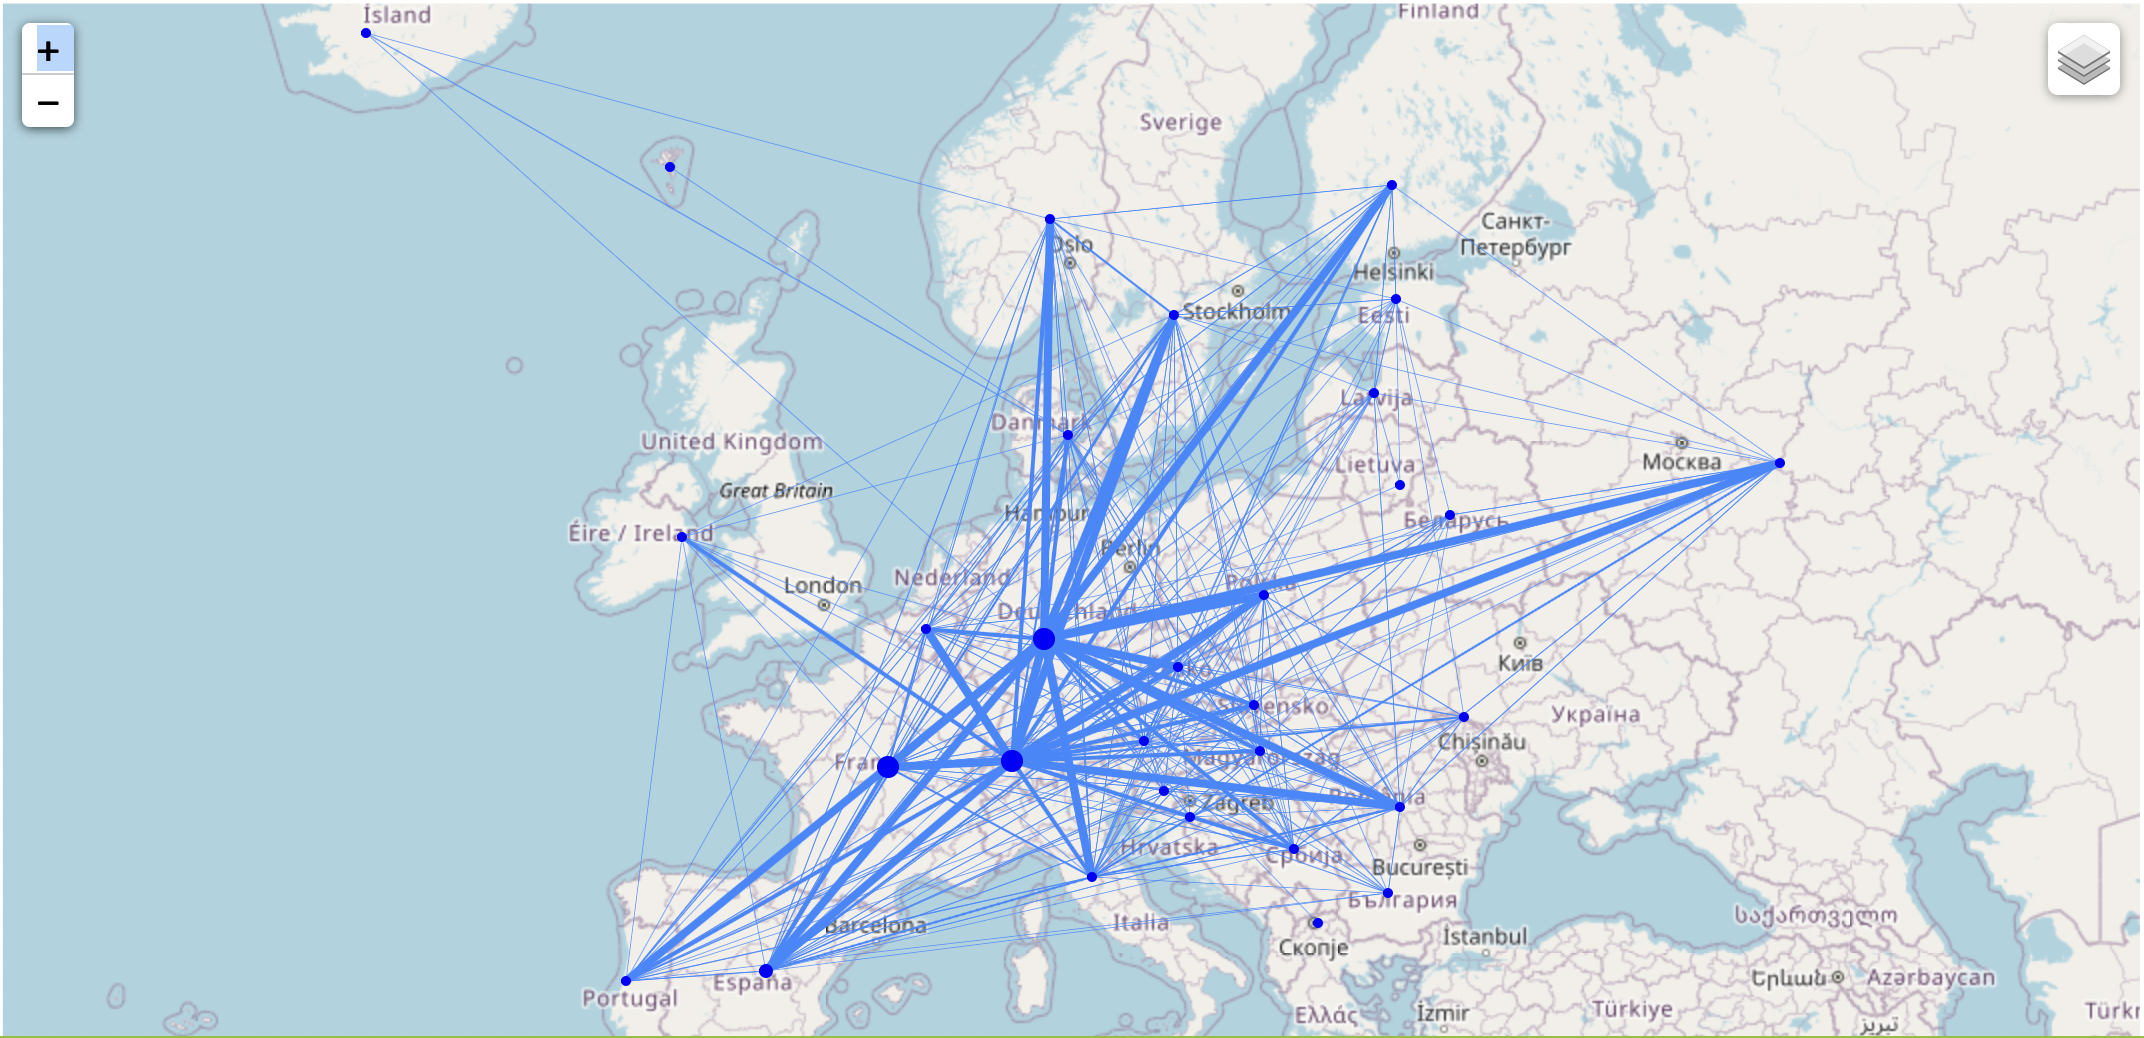

<a id='4.2'></a>
## <font color=li_blue> 4.2 Country Overview </font>

In [21]:
ct_query1=graph_ct.find("(a)-[ab]->(b)").select(col('a.id').alias('a'),'ab.C02Emission','ab.Amount',col('b.id').alias('b'),lit("Out").alias('In-Out')).union(graph_ct.find("(b)-[ab]->(a)").filter('a.id!=b.id').select(col('a.id').alias('a'),'ab.C02Emission','ab.Amount',col('b.id').alias('b'),lit("In").alias('In-Out')))\
.withColumn("Flow_type", when((col('a') == col('b')) & (col('In-Out')=='In'),"Inbound-Domestic").when((col('a') == col('b')) & (col('In-Out')=='Out'),"Outbound-Domestic")\
            .when((col('a') != col('b')) & (col('In-Out')=='In'),"Inbound-Export").when((col('a') != col('b')) & (col('In-Out')=='Out'),"Outbound-Export")
           ).withColumnRenamed("a","Country").withColumnRenamed("b","Trading_Country")
ct_query1.toPandas()  

Country   C02Emission       Amount Trading_Country In-Out  \
0         NL  3.231706e+07  72806616.35              DE    Out   
1         AT  7.365700e+05    320421.59              FI    Out   
2         CZ  3.521552e+05    215693.28              FI    Out   
3         RU  4.359375e+05    622334.87              LV    Out   
4         SE  5.154701e+05    930222.64              LV    Out   
...      ...           ...          ...             ...    ...   
1110      HR  6.119530e+05    310952.77              GB     In   
1111      FO  5.700363e+06   3603798.99              DK     In   
1112      GB  2.748961e+06   1581680.82              SK     In   
1113      AT  6.927597e+06  10227181.64              HU     In   
1114      BA  7.981806e+04     89360.25              CZ     In   

            Flow_type  
0     Outbound-Export  
1     Outbound-Export  
2     Outbound-Export  
3     Outbound-Export  
4     Outbound-Export  
...               ...  
1110   Inbound-Export  
1111   Inbound-Export  
1112   Inbound-Export  
1113   Inbound-Export  
1114   Inbound-Export  

[1115 rows x 6 columns]

 ct_query1 To Maria DB as Trading_Countries

<a id='4.2.1'></a>
### <font color=purple> 4.2.1 What are the most polluting countries? </font>

<div class="alert alert-info">
Identifying where the most of the C02 is concentrated by country, either Outbound or Inbound.<br>
C02 per Kg handled helps to put C02 emmissions relative to the amount of products transported.<br>
 <div>

In [22]:
ct_query1.groupBy("Country")\
              .agg( sum("Amount").alias("Amount"),
                  sum("C02Emission").alias("C02Emission")).withColumn("C02/Kg",col('C02Emission')/col('Amount')).orderBy(col('C02Emission'),ascending = False)\
           .limit(15).toPandas()

Country        Amount   C02Emission    C02/Kg
0       DE  7.524150e+09  4.303877e+09  0.572008
1       CH  5.511075e+09  2.915805e+09  0.529081
2       ES  9.700716e+08  1.018908e+09  1.050343
3       GB  1.374211e+09  9.912700e+08  0.721338
4       FR  1.827819e+09  9.834380e+08  0.538039
5       IT  1.349003e+09  8.563810e+08  0.634825
6       SE  6.036992e+08  5.700058e+08  0.944188
7       PL  6.098104e+08  4.732928e+08  0.776131
8       AT  1.000635e+09  4.285645e+08  0.428293
9       BE  7.074651e+08  3.796889e+08  0.536689
10      NL  6.302011e+08  3.404179e+08  0.540173
11      RU  2.643185e+08  3.188316e+08  1.206240
12      RO  3.825754e+08  3.051737e+08  0.797682
13      FI  2.507684e+08  2.744820e+08  1.094564
14      CZ  5.316665e+08  2.399295e+08  0.451278

<a id='4.2.2'></a>
### <font color=purple> 4.2.2 What flow types are affecting each country the most? </font>

<div class="alert alert-info">
Breakdown each country emission by Inbound/Outbound and Export/Domestic <br>
 <div>

In [23]:
import pyspark.sql.functions as f
ct_query1.where(col('Country')=='DE').groupBy("Country", "Flow_type")\
              .agg( sum("Amount").alias("Amount"),
                  sum("C02Emission").alias("C02Emission")).withColumn("C02/Kg",col('C02Emission')/col('Amount')).orderBy(col('C02Emission'),ascending = False)\
           .limit(10).toPandas()

Country          Flow_type        Amount   C02Emission    C02/Kg
0      DE    Outbound-Export  2.739643e+09  2.482850e+09  0.906268
1      DE     Inbound-Export  2.061575e+09  9.432742e+08  0.457550
2      DE  Outbound-Domestic  2.722933e+09  8.777530e+08  0.322356

<a id='5'></a>
## <font color=li_blue> 5. Analysis on Sources, Destinations and Intercompany Trading </font>

<a id='5.1'></a>
### <font color=purple> 5.1 Sources: What Third Party Sources are produccing more emissions? </font>

<div class="alert alert-info">
Main suppliers locations are identified. <br>
German sources are high in emission but not too high per Kg handled. <br>
On the other hand The Netherlands and UK have higher emissions per Kg handled. <br>
 <div>

In [24]:
g_sources.groupBy("Sources")\
              .agg( sum("Amount").alias("Amount"),
                  sum("C02 Emission").alias("C02Emission")).withColumn("C02/Kg",col('C02Emission')/col('Amount')).orderBy(col('C02Emission'),ascending = False)\
           .limit(10).toPandas()

Sources        Amount   C02Emission    C02/Kg
0    81737-DE  1.422520e+08  1.066359e+08  0.749626
1    21683-DE  1.022672e+08  1.011281e+08  0.988861
2    45128-DE  1.429525e+08  7.552983e+07  0.528356
3     2030-BE  8.828689e+07  5.952783e+07  0.674254
4   E2 8DD-GB  3.621093e+07  5.904216e+07  1.630507
5  3013 AM-NL  5.772824e+07  4.710625e+07  0.816000
6     1180-CH  5.460915e+07  4.104851e+07  0.751678
7    51365-DE  6.581933e+07  3.581852e+07  0.544195
8  LS9 0SW-GB  3.534827e+07  3.403767e+07  0.962923
9  3012 CM-NL  3.514262e+07  3.049598e+07  0.867777

<div class="alert alert-info">
Thermoplastics and Adhesives are the tecnologies with higher emission to be sourced <br>
Concrete Materials and Intercompany materials are highest per KG handled. <br>
 <div>

In [25]:
g_sources.groupBy("Material Cat-Tech")\
              .agg( sum("Amount").alias("Amount"),
                  sum("C02 Emission").alias("C02Emission")).withColumn("C02/Kg",col('C02Emission')/col('Amount')).orderBy(col('C02Emission'),ascending = False)\
           .limit(10).toPandas()

Material Cat-Tech        Amount   C02Emission    C02/Kg
0            Thermoplastics  9.682256e+08  4.910550e+08  0.507170
1          Adhesive Systems  8.119797e+08  4.716731e+08  0.580893
2         Coatings & Resins  6.468618e+08  3.835988e+08  0.593015
3        Concrete Materials  4.015224e+08  2.888608e+08  0.719414
4      Cementitious systems  3.638693e+08  1.833346e+08  0.503847
5              Intercompany  1.826430e+08  1.402081e+08  0.767662
6                 Packaging  2.955232e+08  8.872788e+07  0.300240
7  Automotive Raw Materials  1.082694e+08  4.842207e+07  0.447237

<div class="alert alert-info">
Focusing on the 3 sources with higher emission in Germnay: <br>
Coatings and Resins supplied to Italy, Spain and Portugal have relatively high emission per KG. <br>
 <div>

In [26]:
g_sources.where((col('Sources')=='81737-DE')|(col('Sources')=='21683-DE')|(col('Sources')=='45128-DE')).groupBy("Sources","Destination_Sites","Material Cat-Tech")\
              .agg( sum("Amount").alias("Amount"),
                  sum("C02 Emission").alias("C02Emission")).withColumn("C02/Kg",col('C02Emission')/col('Amount')).orderBy(col('C02Emission'),ascending = False)\
           .limit(10).toPandas()

Sources Destination_Sites     Material Cat-Tech       Amount  \
0  21683-DE          28065-IT     Coatings & Resins  35079640.83   
1  21683-DE          70439-DE     Coatings & Resins  44832920.97   
2  81737-DE          48720-DE  Cementitious systems  38334107.64   
3  81737-DE          20068-IT      Adhesive Systems  34998934.25   
4  45128-DE           3186-CH        Thermoplastics  27537300.15   
5  21683-DE          28108-ES     Coatings & Resins   4742692.30   
6  21683-DE       3880-009-PT     Coatings & Resins   3997901.04   
7  81737-DE         702 36-SE      Adhesive Systems   6459453.14   
8  45128-DE          28065-IT      Adhesive Systems   7166770.81   
9  81737-DE          27240-FR  Cementitious systems   6381520.58   

    C02Emission    C02/Kg  
0  4.083270e+07  1.164000  
1  3.048639e+07  0.680000  
2  2.729664e+07  0.712072  
3  1.879443e+07  0.537000  
4  1.833984e+07  0.666000  
5  1.009245e+07  2.128000  
6  9.830839e+06  2.459000  
7  9.760234e+06  1.511000  
8  6.478761e+06  0.904000  
9  6.107115e+06  0.957000

<div class="alert alert-info">
Concrete Materials supplied from UK to Italy and Spain have high emission factors<br>
Adhesives System from Netherlands to Italy could have room for imporvement too.<br>
 <div>

In [27]:
g_sources.where((col('Sources')=='E2 8DD-GB')|(col('Sources')=='3013 AM-NL')|(col('Sources')=='LS9 0SW-GB')|(col('Sources')=='3012 CM-NL')).groupBy("Sources","Destination_Sites","Material Cat-Tech")\
              .agg( sum("Amount").alias("Amount"),
                  sum("C02 Emission").alias("C02Emission")).withColumn("C02/Kg",col('C02Emission')/col('Amount')).orderBy(col('C02Emission'),ascending = False)\
           .limit(10).toPandas()

Sources Destination_Sites   Material Cat-Tech       Amount  \
0  3013 AM-NL           6060-CH      Thermoplastics  57728244.03   
1   E2 8DD-GB          28108-ES  Concrete Materials  18741490.88   
2  3012 CM-NL           8048-CH    Adhesive Systems  22423789.43   
3   E2 8DD-GB          89048-IT  Concrete Materials   5393230.05   
4   E2 8DD-GB          28065-IT  Concrete Materials   8803320.76   
5  3012 CM-NL          28065-IT    Adhesive Systems   8331240.77   
6  LS9 0SW-GB         702 36-SE    Adhesive Systems   2158017.88   
7  3012 CM-NL           3186-CH    Adhesive Systems   4114194.57   
8  LS9 0SW-GB            D11-IE        Intercompany   8223170.84   
9  LS9 0SW-GB          70499-DE        Intercompany   2397098.38   

    C02Emission    C02/Kg  
0  4.710625e+07  0.816000  
1  3.184179e+07  1.699000  
2  1.811842e+07  0.808000  
3  1.338060e+07  2.481000  
4  1.113620e+07  1.265000  
5  8.810845e+06  1.057567  
6  4.495151e+06  2.083000  
7  3.369525e+06  0.819000  
8  3.272822e+06  0.398000  
9  2.924460e+06  1.220000

<a id='5.2'></a>
### <font color=purple> 5.2 Destinations: Where are the higher emission supplying customers? </font>

<div class="alert alert-info">
Medium size companies such as Greece, Ukraine, Latvia and Bulgaria have relatively high emissions.<br>
 <div>

In [28]:
g_targets.groupBy("Destination")\
              .agg( sum("Amount").alias("Amount"),
                  sum("C02 Emission").alias("C02Emission")).withColumn("C02/Kg",col('C02Emission')/col('Amount')).orderBy(col('C02Emission'),ascending = False)\
           .limit(10).toPandas()

Destination        Amount   C02Emission    C02/Kg
0    93350-FR  2.405335e+08  1.540307e+08  0.640371
1   145 68-GR  4.093419e+07  1.024260e+08  2.502211
2    03038-UA  2.103791e+07  4.369546e+07  2.076986
3     3520-DK  4.467639e+07  4.112499e+07  0.920508
4  CV3 9HE-GB  3.555459e+07  3.778532e+07  1.062741
5   405 31-SE  2.430330e+07  3.235962e+07  1.331491
6  LS9 0SW-GB  5.442491e+07  3.061470e+07  0.562513
7    80788-DE  7.658274e+07  2.971809e+07  0.388052
8     1073-LV  1.692839e+07  2.843171e+07  1.679529
9     1504-BG  2.082089e+07  2.841717e+07  1.364839

<div class="alert alert-info">
Adhesive and Cementitous systems are the highest in absolute C02.<br>
CO2 per KG is on average lower in destinations (0.3-0.4) in comparison with sources (0.5-1.5) .<br>
 <div>

In [29]:
g_targets.groupBy("Material Cat-Tech")\
              .agg( sum("Amount").alias("Amount"),
                  sum("C02 Emission").alias("C02Emission")).withColumn("C02/Kg",col('C02Emission')/col('Amount')).orderBy(col('C02Emission'),ascending = False)\
           .limit(10).toPandas()

Material Cat-Tech        Amount   C02Emission    C02/Kg
0     Adhesives systems  2.184411e+09  9.234438e+08  0.422743
1    Cementious systems  1.223301e+09  3.856838e+08  0.315281
2       Coating systems  9.436968e+08  3.764441e+08  0.398904
3      Concrete Systems  9.969982e+08  3.684394e+08  0.369549
4          Specialities  5.063947e+08  3.555109e+08  0.702043
5  Thermoplastic system  1.076165e+09  3.266846e+08  0.303564
6               Various  7.031623e+07  2.731269e+07  0.388427
7          Intercompany  4.352312e+06  7.387760e+06  1.697433
8      Adhesive Systems  2.620058e+06  5.214702e+06  1.990300
9        Thermoplastics  3.233746e+05  6.279384e+05  1.941829

<div class="alert alert-info">
Greece high emission on Adhesives, Coatings and Concrete systems (Factories in Germany/UK/Spain).<br>
Thermoplastics from Switzerland to Greece and Ukraine .<br>
Specialties from  Switzerland to Sweden .<br>
 <div>

In [30]:
g_targets.where((col('Destination')=='145 68-GR')|(col('Destination')=='03038-UA')|(col('Destination')=='405 31-SE')|(col('Destination')=='1504-BG')).groupBy("Destination","Origin_Sites","Material Cat-Tech")\
              .agg( sum("Amount").alias("Amount"),
                  sum("C02 Emission").alias("C02Emission")).withColumn("C02/Kg",col('C02Emission')/col('Amount')).orderBy(col('C02Emission'),ascending = False)\
           .limit(10).toPandas()

Destination Origin_Sites     Material Cat-Tech       Amount   C02Emission  \
0   405 31-SE      8590-CH          Specialities  14719800.75  2.184707e+07   
1   145 68-GR     70499-DE     Adhesives systems   7660691.50  1.727504e+07   
2   145 68-GR   PR1 1EA-GB       Coating systems   4509826.76  1.570093e+07   
3    03038-UA      3186-CH  Thermoplastic system   6858211.98  1.537887e+07   
4   145 68-GR     28108-ES      Concrete Systems   4171268.12  1.330217e+07   
5   405 31-SE     63526-DE     Adhesives systems   8114609.95  9.063419e+06   
6    03038-UA     70499-DE     Adhesives systems   4542788.37  8.585756e+06   
7   145 68-GR      6060-CH  Thermoplastic system   4170218.55  8.268234e+06   
8     1504-BG      3186-CH  Thermoplastic system   3958221.37  7.013521e+06   
9     1504-BG      6060-CH  Thermoplastic system   3789753.24  6.226072e+06   

     C02/Kg  
0  1.484196  
1  2.255023  
2  3.481494  
3  2.242402  
4  3.189000  
5  1.116926  
6  1.889975  
7  1.982686  
8  1.771887  
9  1.642870

<a id='5.3'></a>
### <font color=purple> 5.3 Intercompany:Analyzing business among factories->Nodes with bidirectional trading</font>

<div class="alert alert-info">
Germany has dual traiding with Spain, Switzerland and Italy for technologies which are similar. .<br>
Could this redundancy reduced or eliminated?
 <div>

In [31]:
g_bidir_trad.where(col('ab_Material Cat-Tech')==col('ba_Material Cat-Tech')).limit(20).toPandas()   

SiteA         atype  ab_C02Emission     ab_Amount  \
0     70499-DE  Intermediate    1.078148e+08  6.203386e+07   
1     28108-ES  Intermediate    6.999311e+06  4.027222e+06   
2     22525-DE  Intermediate    5.165196e+04  5.524274e+04   
3      6060-CH  Intermediate    9.937302e+07  1.062813e+08   
4     28065-IT  Intermediate    5.702257e+07  1.082022e+08   
5     70499-DE  Intermediate    1.316520e+03  2.498140e+03   
6      8048-CH  Intermediate    5.501181e+07  2.500537e+08   
7     70499-DE  Intermediate    8.250569e+05  3.750259e+06   
8      6060-CH  Intermediate    5.428805e+07  1.779936e+08   
9     70439-DE  Intermediate    2.685688e+04  8.805535e+04   
10    70439-DE  Intermediate    5.514560e+04  1.808052e+05   
11     6060-CH  Intermediate    2.819542e+07  9.244402e+07   
12    70499-DE  Intermediate    3.683414e+02  6.989400e+02   
13    28065-IT  Intermediate    2.553535e+07  4.845417e+07   
14    28108-ES  Intermediate    1.271368e+07  7.264958e+06   
15  AL7 1BQ-GB  Intermediate    8.903461e+06  5.087692e+06   
16    28108-ES  Intermediate    0.000000e+00  0.000000e+00   
17     6060-CH  Intermediate    1.559282e+07  9.484683e+06   
18     6060-CH  Intermediate    1.251510e+07  1.317379e+08   
19     5242-CH  Intermediate    3.028077e+03  3.187450e+04   

    ab_Material Cat-Tech ab_InBound-OutBound       SiteB         btype  \
0      Adhesives systems            Outbound    28108-ES  Intermediate   
1      Adhesives systems            Outbound    70499-DE  Intermediate   
2           Intercompany             Inbound     6060-CH  Intermediate   
3           Intercompany             Inbound    22525-DE  Intermediate   
4           Specialities            Outbound    70499-DE  Intermediate   
5           Specialities            Outbound    28065-IT  Intermediate   
6      Adhesives systems            Outbound    70499-DE  Intermediate   
7      Adhesives systems            Outbound     8048-CH  Intermediate   
8           Intercompany             Inbound    70439-DE  Intermediate   
9           Intercompany             Inbound     6060-CH  Intermediate   
10  Thermoplastic system            Outbound     6060-CH  Intermediate   
11  Thermoplastic system            Outbound    70439-DE  Intermediate   
12     Adhesives systems            Outbound    28065-IT  Intermediate   
13     Adhesives systems            Outbound    70499-DE  Intermediate   
14          Intercompany             Inbound  AL7 1BQ-GB  Intermediate   
15          Intercompany             Inbound    28108-ES  Intermediate   
16  Thermoplastic system            Outbound     6060-CH  Intermediate   
17  Thermoplastic system            Outbound    28108-ES  Intermediate   
18          Intercompany             Inbound     5242-CH  Intermediate   
19          Intercompany             Inbound     6060-CH  Intermediate   

    ba_C02Emission     ba_Amount  ba_Material Cat-Tech ba_InBound-OutBound  \
0     6.999311e+06  4.027222e+06     Adhesives systems            Outbound   
1     1.078148e+08  6.203386e+07     Adhesives systems            Outbound   
2     9.937302e+07  1.062813e+08          Intercompany             Inbound   
3     5.165196e+04  5.524274e+04          Intercompany             Inbound   
4     1.316520e+03  2.498140e+03          Specialities            Outbound   
5     5.702257e+07  1.082022e+08          Specialities            Outbound   
6     8.250569e+05  3.750259e+06     Adhesives systems            Outbound   
7     5.501181e+07  2.500537e+08     Adhesives systems            Outbound   
8     2.685688e+04  8.805535e+04          Intercompany             Inbound   
9     5.428805e+07  1.779936e+08          Intercompany             Inbound   
10    2.819542e+07  9.244402e+07  Thermoplastic system            Outbound   
11    5.514560e+04  1.808052e+05  Thermoplastic system            Outbound   
12    2.553535e+07  4.845417e+07     Adhesives systems            Outbound   
13    3.683414e+02  6.989400e+02     Adhesives systems     

<a id='6'></a>

### <font color=li_blue> 6. Analyzing the most common routes </font>
### <font color=purple>6.1 Which are the top 5 most popular routes of the country of interest?</font>

In [32]:
subgraph = GraphFrame(graph_trip.vertices, graph_trip.edges.where("src_ctry='Germany'"))
routes = subgraph.edges.orderBy(desc("trip_count"))

routes.limit(5).toPandas()

src       dst src_ctry dst_ctry  trip_count  Distance_avg  \
0  70499-DE  92369-DE  Germany       DE          16       226.436   
1  70499-DE  45478-DE  Germany       DE          15       413.202   
2  70499-DE  34123-DE  Germany       DE          15       345.731   
3  70499-DE  48683-DE  Germany       DE          14       506.587   
4  70499-DE  12681-DE  Germany       DE          13       673.159   

   C02Emission_avg  
0     37058.959999  
1      7746.385768  
2     48169.960135  
3    101222.091084  
4     46275.472971

In [33]:
routes 

DataFrame[src: string, dst: string, src_ctry: string, dst_ctry: string, trip_count: bigint, Distance_avg: double, C02Emission_avg: double]

<a id='6.2'></a>
### <font color=purple> 6.2 Which are the Hubs where most of the trips/routes depart from? </font>

In [34]:
outDeg = graph.outDegrees
outDeg.orderBy(desc("outDegree")).limit(10).toPandas()

id  outDegree
0    76220-FR      12387
1    28108-ES       6022
2    70499-DE       5301
3    13450-FR       4742
4    41049-IT       4188
5     5242-CH       3337
6  LU5 5UL-GB       2838
7    70439-DE       2260
8   500450-RO       2186
9     9810-BE       2016

In [35]:
#Scheme for Mongo DB
outDeg.printSchema()

root
 |-- id: string (nullable = true)
 |-- outDegree: integer (nullable = false)



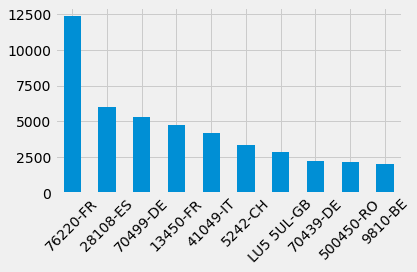

In [36]:
#Graphical View of the outDegreees
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

ax = (outDeg.orderBy(desc("outDegree"))
      .toPandas()
      .head(10)
      .plot(kind='bar', x='id', y='outDegree', legend=None))

ax.xaxis.set_label_text("")
#plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<a id='6.3'></a>
### <font color=purple> 6.3 Which are the Hubs where the lowest trips/routes depart from? </font>

In [37]:
outDeg.join(graph.vertices,"id").orderBy(asc("outDegree"),asc("id")).limit(5).toPandas()

id  outDegree Country  Region      Lat      Lon    Type  Distance  \
0  01010-ES          1      ES  Europe  42.8548  -2.7017  Target  2661.744   
1  01010-ES          1      ES  Europe  42.8548  -2.7017  Source   332.718   
2  01099-DE          1      DE  Europe  51.0783  13.8051  Source   507.704   
3  01099-DE          1      DE  Europe  51.0783  13.8051  Target  1015.408   
4  01100-FR          1      FR  Europe  46.2592   5.6573  Source   582.618   

    C02Emission  Percentile  
0  10843.259657         2.0  
1   9000.421162         2.0  
2  25985.884911         4.0  
3    258.340103         0.0  
4  63155.307627         6.0

<a id='6.4'></a>
### <font color=purple> 6.4 Which are the Hubs where most of the trips get to? </font>

In [38]:
inDeg = graph.inDegrees
inDeg.orderBy(desc("inDegree"),asc("id")).limit(10).toPandas()

id  inDegree
0    28108-ES       448
1    76220-FR       429
2    70439-DE       400
3     8048-CH       382
4   02-871-PL       349
5  AL7 1BQ-GB       329
6     6700-AT       310
7    41049-IT       306
8    22525-DE       301
9   500450-RO       296

In [39]:
#Scheme for Mongo DB
inDeg.printSchema()

root
 |-- id: string (nullable = true)
 |-- inDegree: integer (nullable = false)



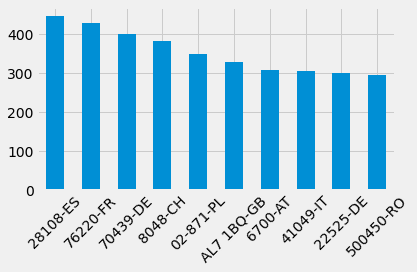

In [40]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

ax = (inDeg.orderBy(desc("inDegree"))
      .toPandas()
      .head(10)
      .plot(kind='bar', x='id', y='inDegree', legend=None))

ax.xaxis.set_label_text("")
#plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<a id='7'></a>
## <font color=li_blue> 7. Optimizations</font>
<a id='7.1'></a>
## <font color=li_blue> 7.1 Breadth-first search (BFS)</font>

<a id='7.1.1'></a>
### <font color=purple> 7.1.1 What is the shortest Hub? </font>

<div class="alert alert-info">
    <b>NOTE</b>: Spark's BFS (Breadth-first search) computes the shortest paths in terms of the <b>number of hubs</b> between to vertices. It does <b>not</b> take edge weights into account. There are alternatives to take edge weights into consideration but, unfortunately, it's out of the scope of this course.Check with the entire dataset, shortest path from hubs: Select the Hubs of your interst and check the shortest path 
</div>

In [41]:
graph.edges.where('src = "70499-DE"').where('dst = "145 68-GR"').toPandas()

_c0       src Origin_Postal_Code           Origin_City Origin_Country  \
0  54106  70499-DE              70499  Stuttgart-Weilimdorf             DE   
1  54110  70499-DE              70499  Stuttgart-Weilimdorf             DE   
2  54107  70499-DE              70499  Stuttgart-Weilimdorf             DE   
3  54105  70499-DE              70499  Stuttgart-Weilimdorf             DE   
4  54108  70499-DE              70499  Stuttgart-Weilimdorf             DE   
5  54109  70499-DE              70499  Stuttgart-Weilimdorf             DE   

  src_ctry Origin_Region Origin_Plant        dst Target_Postal_Code  \
0  Germany        Europe         DE70  145 68-GR             145 68   
1  Germany        Europe         DE70  145 68-GR             145 68   
2  Germany        Europe         DE70  145 68-GR             145 68   
3  Germany        Europe         DE70  145 68-GR             145 68   
4  Germany        Europe         DE70  145 68-GR             145 68   
5  Germany        Europe         DE70  145 68-GR             145 68   

       Target_City dst_ctry Target_Country_Name Target_Region Target_Plant  \
0  Kryoneri Attiki       GR              Greece        Europe         None   
1  Kryoneri Attiki       GR              Greece        Europe         None   
2  Kryoneri Attiki       GR              Greece        Europe         None   
3  Kryoneri Attiki       GR              Greece        Europe         None   
4  Kryoneri Attiki       GR              Greece        Europe         None   
5  Kryoneri Attiki       GR              Greece        Europe         None   

  InBound-OutBound     Material Cat-Tech      Amount  Distance  C02 Emission  \
0         Outbound       Coating systems  2026335.63  2255.023  4.569433e+06   
1         Outbound               Various     1202.53  2255.023  2.711733e+03   
2         Outbound      Concrete Systems      565.42  2255.023  1.275035e+03   
3         Outbound     Adhesives systems  7660691.50  2255.023  1.727504e+07   
4         Outbound          Specialities    33975.82  2255.023  7.661626e+04   
5         Outbound  Thermoplastic system    10556.02  2255.023  2.380407e+04   

   Origin_Lat  Origin_Lon  Target_Lat  Target_Lon  
0     48.8143      9.1123         NaN         NaN  
1     48.8143      9.1123         NaN         NaN  
2     48.8143      9.1123         NaN         NaN  
3     48.8143      9.1123         NaN         NaN  
4     48.8143      9.1123         NaN         NaN  
5     48.8143      9.1123         NaN         NaN

#Breadth-first search (BFS) finds the shortest path(s) from one vertex (or a set of vertices) to another vertex (or a set of vertices). The beginning and end vertices are specified as Spark DataFrame expressions.

In [42]:
paths = graph.bfs(fromExpr = "id = '70499-DE'", toExpr= "id = '145 68-GR'")
paths.toPandas()

from  \
0   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
1   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
2   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
3   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
4   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
5   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
6   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
7   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
8   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
9   (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
10  (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   
11  (70499-DE, DE, Europe, 48.8143, 9.1123, Interm...   

                                                   e0  \
0   (54106, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
1   (54106, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
2   (54110, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
3   (54110, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
4   (54107, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
5   (54107, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
6   (54105, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
7   (54105, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
8   (54108, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
9   (54108, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
10  (54109, 70499-DE, 70499, Stuttgart-Weilimdorf,...   
11  (54109, 70499-DE, 70499, Stuttgart-Weilimdorf,...   

                                                   to  
0   (145 68-GR, GR, Europe, None, None, Source, 15...  
1   (145 68-GR, GR, Europe, None, None, Target, 21...  
2   (145 68-GR, GR, Europe, None, None, Source, 15...  
3   (145 68-GR, GR, Europe, None, None, Target, 21...  
4   (145 68-GR, GR, Europe, None, None, Source, 15...  
5   (145 68-GR, GR, Europe, None, None, Target, 21...  
6   (145 68-GR, GR, Europe, None, None, Source, 15...  
7   (145 68-GR, GR, Europe, None, None, Target, 21...  
8   (145 68-GR, GR, Europe, None, None, Source, 15...  
9   (145 68-GR, GR, Europe, None, None, Target, 21...  
10  (145 68-GR, GR, Europe, None, None, Source, 15...  
11  (145 68-GR, GR, Europe, None, None, Target, 21...

<a id='7.2'></a>
## <font color=li_blue> 7.2 Connected & Strongly connected component  </font>

<div class="alert alert-info">
Compute the strongly connected component (SCC) of each vertex and return a DataFrame with each vertex assigned to the SCC containing that vertex.
</div>

In [43]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
ssc = StreamingContext(sc, 1)
ssc.checkpoint("/tmp/spark")
result = graph.connectedComponents()
result.select("id", "component").orderBy("component").show()

+---------+---------+
|       id|component|
+---------+---------+
| 51140-FR|        0|
|32-800-PL|        0|
| 41840-ES|        0|
| 40600-FR|        0|
|  8472-CH|        0|
|107250-RO|        0|
|786 97-SE|        0|
|188681-RU|        0|
| 38121-FR|        0|
| 28925-ES|        0|
|  3027-CH|        0|
| 26452-DE|        0|
| 57970-FR|        0|
|  1740-BE|        0|
|  9019-NO|        0|
| 41569-DE|        0|
|  1600-BE|        0|
|  4671-BE|        0|
| 73079-DE|        0|
|  9280-BE|        0|
+---------+---------+
only showing top 20 rows



In [44]:
#  connected garphs

from pyspark import SparkContext
from pyspark.streaming import StreamingContext
ssc = StreamingContext(sc, 1)
ssc.checkpoint("/tmp/spark")
result = graph.connectedComponents()
result.select("id", "component").orderBy("component")

result.groupBy('component').count().orderBy('count', ascending=False).show()

+------------+-----+
|   component|count|
+------------+-----+
|           0|17583|
|773094113359|    2|
+------------+-----+



In [45]:
result2 = graph.stronglyConnectedComponents(maxIter=10)
strong_conn = result2.select("id", "component")
display(result2.select("id", "component"))
result2.groupBy('component').count().orderBy('count', ascending=False).show()

DataFrame[id: string, component: bigint]

+------------+-----+
|   component|count|
+------------+-----+
|           1| 2933|
|223338299404|    3|
|343597383693|    2|
|          26|    1|
|          29|    1|
|  8589934658|    1|
| 60129542213|    1|
| 77309411361|    1|
|137438953476|    1|
| 34359738398|    1|
|214748364866|    1|
| 68719476798|    1|
|377957122049|    1|
| 94489280590|    1|
|146028888066|    1|
|163208757352|    1|
|206158430228|    1|
|240518168636|    1|
|257698037791|    1|
|335007449116|    1|
+------------+-----+
only showing top 20 rows



result2 into MariaDB as strong_connected

<a id='7.3'></a>
## <font color=li_blue> 7.3 Label Propagation  </font>

<div class="alert alert-info"> Run static Label Propagation Algorithm for detecting communities in networks.
Each node in the network is initially assigned to its own community. At every superstep, nodes send their community affiliation to all neighbors and update their state to the most frequent community affiliation of incoming messages.
LPA is a standard community detection algorithm for graphs. It is very inexpensive computationally, although (1) convergence is not guaranteed and (2) one can end up with trivial solutions (all nodes are identified into a single community)
</div>

In [46]:
result_lp = graph.labelPropagation(maxIter=5)
result_lp.select("id", "label").show()

+---------+-------------+
|       id|        label|
+---------+-------------+
| 51140-FR| 240518168632|
|32-800-PL| 712964571137|
| 41840-ES| 214748364819|
| 40600-FR|1159641169931|
|  8472-CH| 111669149735|
|107250-RO|1692217114659|
|786 97-SE|1589137899537|
|188681-RU| 670014898188|
| 38121-FR| 240518168632|
| 28925-ES| 214748364819|
|  3027-CH| 111669149735|
| 26452-DE| 901943132208|
| 57970-FR| 240518168632|
|  1740-BE| 618475290695|
|  9019-NO| 438086664205|
| 41569-DE| 893353197604|
|  1600-BE| 618475290695|
|  4671-BE| 618475290695|
| 73079-DE| 901943132208|
|  9280-BE| 618475290695|
+---------+-------------+
only showing top 20 rows



result_lp to Maria DB as communities

<a id='7.4'></a>
## <font color=li_blue> 7.4 Shortest Path  </font>

<a id='7.4.1'></a>
### <font color=purple> 7.4.1 Shortest Path (Weighted) </font>

<div class="alert alert-info"> In the Breadth First Search with Apache Spark section we learned how to find the shortest path between two nodes. That shortest path was based on hops and therefore isn’t the same as the shortest weighted path, which would tell us the shortest total dis‐ tance between cities.</div>

In [47]:
from pyspark.sql.functions import count,avg,desc,asc,col
from graphframes import GraphFrame

print ("  2a. Creating the vertices")
origin_keys=c02.select("Origin_Key").distinct()
target_keys=c02.select("Target_Key").distinct()
nodes=origin_keys.union(target_keys).distinct()
print ("  2b. Creating the edges")
# edges=stations.select("Origin_Key",'Target_Key').distinct(

# GraphFrames requires the vertices DataFrame to have a column named id.
vertices = nodes.withColumnRenamed("Origin_Key","id")
    
# GraphFrames requires the edges DataFrame to have columns named src and dst
trips = (c02.withColumnRenamed("Origin_Key", "src")
              .withColumnRenamed("Target_Key", "dst")
              .withColumnRenamed("Origin_Country_Name","src_ctry")
             .withColumnRenamed("Target_Country","dst_ctry")
        )
              
edges = (trips.groupBy("src", "dst", "src_ctry", "dst_ctry")
              .agg(
                  count("*").alias("trip_count"),
                  avg("Distance").alias("Distance"),
                  avg("C02 Emission").alias("C02Emission_avg")
              ))


     
# Creates the graph
graph_trip = GraphFrame(vertices, edges)

# graph processing requires recursive/iterative calculations so is a good practice to cache
graph_trip.cache()

  2a. Creating the vertices
  2b. Creating the edges


GraphFrame(v:[id: string], e:[src: string, dst: string ... 5 more fields])

In [48]:
from collections import defaultdict
from collections import Set
import sys

def shortest_path_with_weights(vertices, edges, source_vertex):

    distances = defaultdict(float)
    predecessors = {}
    edges_dict = defaultdict(list)
    unvisited_vertices = set([])

    for vertex in vertices.collect():
        distances[vertex['id']] = sys.float_info.max
        unvisited_vertices.add(vertex['id'])

    distances[source_vertex] = 0.0

    for edge in edges.collect():
        if(edge['Distance'] <= 0.0):
            print(edge)
        edges_dict[edge['src']].append(edge)
    
    min_distance_last_visited_vertex = 0.0
    last_visited_vertex = source_vertex

    while min_distance_last_visited_vertex < sys.float_info.max and len(unvisited_vertices) > 0:
        current_vertex, min_distance_source_to_current_vertex = get_min_distance_vertex(unvisited_vertices, distances)
        if min_distance_source_to_current_vertex < sys.float_info.max:
            for edge in edges_dict[current_vertex]:
                if(distances[current_vertex] + edge['Distance'] < distances[edge['dst']]):
                    distances[edge['dst']] = distances[current_vertex] + edge['Distance']
                    predecessors[edge['dst']] = edge 
            unvisited_vertices.remove(current_vertex)

        min_distance_last_visited_vertex = min_distance_source_to_current_vertex
        

    return distances, predecessors

def get_min_distance_vertex(unvisited_vertices, distances):
    min_distance = sys.float_info.max
    min_distance_vertex = ''
    for vertex in unvisited_vertices:
        if distances[vertex] < min_distance:
            min_distance = distances[vertex]
            min_distance_vertex = vertex
    return min_distance_vertex, min_distance

distances, predecessors = shortest_path_with_weights(vertices, edges, '70499-DE')
print(distances)

/tmp/ipykernel_908/2280879157.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Set


defaultdict(<class 'float'>, {'01740-FI': 1955.521, '69745-FR': 909.932, '01510-FI': 1963.9859999999999, '143907-RU': 1.7976931348623157e+308, '601220-RU': 2590.6569999999997, '606031-RU': 1.7976931348623157e+308, 'DE12 7DS-GB': 1636.333, '9700-BE': 614.9680000000001, '387 35-SE': 1480.885, '20093-IT': 1.7976931348623157e+308, '03006-ES': 2166.523, '46450-ES': 2115.0, '41334-DE': 431.0, '4425-364-PT': 1.7976931348623157e+308, '4765-080-PT': 1.7976931348623157e+308, 'SAT COZANESTI-RO': 1.7976931348623157e+308, '8791-BE': 1.7976931348623157e+308, '8773-AT': 1.7976931348623157e+308, '6331-CH': 257.131, '7940 AA-NL': 1.7976931348623157e+308, '60290-FR': 1.7976931348623157e+308, '73235-DE': 1.7976931348623157e+308, 'LL13 9UG-GB': 1.7976931348623157e+308, '20-052-PL': 1370.563, '44-240-PL': 1454.046, '53-234-PL': 1477.121, '97-350-PL': 1281.493, '11648-ES': 2370.313, '01400-FR': 1223.768, '63100-FR': 1177.454, '69630-FR': 1177.0, '6230-NO': 1959.9070000000002, '6718-NO': 1993.738, '9515-NO':

In [49]:
def get_path(predecessors, src_vertex, dst_vertex):
    intermediate_vertex = dst_vertex
    edges = []
    while intermediate_vertex != src_vertex:
        predecessor = predecessors[intermediate_vertex]
        edges.append(predecessor)
        intermediate_vertex = predecessor['src']
    return list(reversed(edges))

def print_distance_path(src_vertex, dst_vertex, distances, predecessors):
    print(f"Distance from {src_vertex} to {dst_vertex}: {distances[dst_vertex]}")
    path = get_path(predecessors, src_vertex, dst_vertex)
    for edge in path:
        print(f"Go from {edge['src']} to {edge['dst']} with distance {edge['Distance']}")
    
print_distance_path('70499-DE', '145 68-GR', distances, predecessors)
# 70499-DE'", toExpr= "id = '145 68-GR

Distance from 70499-DE to 145 68-GR: 2240.811
Go from 70499-DE to 5242-CH with distance 203.0
Go from 5242-CH to 145 68-GR with distance 2037.8110000000001


And now for the main function, which calculates the shortest path starting from an
origin and returns as soon as the destination has been visited

<a id='7.5'></a>
## <font color=li_blue> 7.5 All Pairs Shortest Path  </font>

<div class="alert alert-info"> If we wanted to find the shortest path from every location to Greece we would write the following query:<div>

In [50]:
print (" Running the All Pair Shortest path algorithm to get from every location (be patient)...")
result = graph.shortestPaths(["145 68-GR"])
result.sort(["Distance"]).select("id", "distances").show(truncate=False)

 Running the All Pair Shortest path algorithm to get from every location (be patient)...


+------------------+----------------+
|id                |distances       |
+------------------+----------------+
|7418 CS-NL        |{145 68-GR -> 2}|
|26300-FR          |{145 68-GR -> 2}|
|7417 XL-NL        |{}              |
|500164-RO         |{145 68-GR -> 3}|
|3880-218-PT       |{145 68-GR -> 2}|
|7400 GC-NL        |{}              |
|3542 AV-NL        |{}              |
|SFANTU GHEORGHE-RO|{145 68-GR -> 2}|
|26540-FR          |{145 68-GR -> 2}|
|6064-CH           |{145 68-GR -> 2}|
|7418 ES-NL        |{145 68-GR -> 2}|
|3880-161-PT       |{145 68-GR -> 2}|
|6072-CH           |{145 68-GR -> 2}|
|7418 EX-NL        |{145 68-GR -> 2}|
|SG14 2NR-GB       |{}              |
|1230-SI           |{145 68-GR -> 3}|
|53842-DE          |{145 68-GR -> 2}|
|5212-CH           |{145 68-GR -> 2}|
|53721-DE          |{145 68-GR -> 2}|
|08420-ES          |{}              |
+------------------+----------------+
only showing top 20 rows



In [51]:
result.limit(5).toPandas()

id Country  Region      Lat      Lon    Type   Distance  \
0   51140-FR      FR  Europe  49.3167   3.7667  Target   1069.134   
1  32-800-PL      PL  Europe  49.9619  20.8512  Target   1463.010   
2   41840-ES      ES  Europe  37.3034  -6.3010  Target   3552.504   
3   40600-FR      FR  Europe  44.3945  -1.1672  Target  12091.748   
4    8472-CH      CH  Europe  47.5343   8.7261  Target    239.184   

    C02Emission  Percentile distances  
0  41397.755861         5.0        {}  
1  39777.966155         5.0        {}  
2  27700.697307         4.0        {}  
3  79209.797052         6.0        {}  
4   3736.741734         1.0        {}

<a id='7.6'></a>
## <font color=li_blue> 7.6 PageRank  </font>

<div class="alert alert-info"> Let's use the PageRank algorithm to identify the top 5 most popular Hubs.<div>

In [52]:
print (" Running the PageRank algorithm to get the top 5 most popular Hubs (be patient)...")
from pyspark.sql.functions import desc
ranks = graph.pageRank(resetProbability=0.15, maxIter=10)
ranks.vertices.orderBy(desc("pagerank")).select("id", "pagerank").show(5)


 Running the PageRank algorithm to get the top 5 most popular Hubs (be patient)...


+---------+------------------+
|       id|          pagerank|
+---------+------------------+
| 76220-FR|  105.586422542862|
| 28108-ES|104.18545119871885|
|141733-RU| 89.09444026875772|
|  6060-CH| 86.04389617150491|
| 41049-IT| 84.06623590847136|
+---------+------------------+
only showing top 5 rows



In [53]:
pagerank = ranks.vertices.orderBy(desc("pagerank")).select("id", "pagerank")

pagerank to MariaDB as pagerank

<a id='8'></a>
## <font color=li_blue> 8. Store the results in MariaDB</font>

<div class="alert alert-info">
 <b>NOTE</b>: We're going to store the results of the graph analytics in a MariaDB database (previously created) to let analysts use our BI tool Superset and visualize insights (rather than force them to use the notebook).<br/>
These are the coordinates to connect to our MariaDB instance:
 </div>

In [54]:
import os

os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/share/java/mariadb-java-client.jar pyspark-shell'

In [55]:
from pyspark.sql.session import SparkSession

<a id='8.1'></a>
### <font color=purple> 8.1 Countries</font>

In [56]:
df_countries2.limit(5).toPandas()

Country  Region        Lat        Lon     Distance   C02Emission  \
0      MK  Europe  41.996100  21.582200     3652.835  1.577638e+06   
1      RU  Europe  55.224720  41.963869  2473268.599  4.053125e+08   
2      PT  Europe  40.055481  -8.755639  1286034.720  2.503045e+08   
3      AD  Europe        NaN        NaN    11846.170  1.383629e+06   
4      AL  Europe        NaN        NaN    58862.361  8.806841e+06   

   Percentile  size  
0         1.0   0.1  
1        15.0   0.1  
2        13.0   0.1  
3         1.0   0.1  
4         4.0   0.1

In [57]:
spark = (SparkSession.builder
    .appName("scope3 - Graph - Results")
    .getOrCreate())

In [58]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "countries"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [59]:
countries = spark.createDataFrame(df_countries2.toPandas())

In [60]:
countries.limit(5).toPandas()

Country  Region        Lat        Lon     Distance   C02Emission  \
0      MK  Europe  41.996100  21.582200     3652.835  1.577638e+06   
1      RU  Europe  55.224720  41.963869  2473268.599  4.053125e+08   
2      PT  Europe  40.055481  -8.755639  1286034.720  2.503045e+08   
3      AD  Europe        NaN        NaN    11846.170  1.383629e+06   
4      AL  Europe        NaN        NaN    58862.361  8.806841e+06   

   Percentile  size  
0         1.0   0.1  
1        15.0   0.1  
2        13.0   0.1  
3         1.0   0.1  
4         4.0   0.1

In [61]:
#Replace 0 for null for all integer columns
countries = countries.na.fill(value=0)

In [62]:
countries.limit(5).toPandas()

Country  Region        Lat        Lon     Distance   C02Emission  \
0      MK  Europe  41.996100  21.582200     3652.835  1.577638e+06   
1      RU  Europe  55.224720  41.963869  2473268.599  4.053125e+08   
2      PT  Europe  40.055481  -8.755639  1286034.720  2.503045e+08   
3      AD  Europe   0.000000   0.000000    11846.170  1.383629e+06   
4      AL  Europe   0.000000   0.000000    58862.361  8.806841e+06   

   Percentile  size  
0         1.0   0.1  
1        15.0   0.1  
2        13.0   0.1  
3         1.0   0.1  
4         4.0   0.1

In [63]:
type(countries)

pyspark.sql.dataframe.DataFrame

In [64]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_c = countries.select(col("Country").alias("country"), \
                                  col('Region').alias("region"),\
                                  col('Lat').alias("lat"),\
                                  col('Lon').alias("lon"),\
                                  col('Distance').alias("distance"),\
                                  col('C02Emission').alias("c02emission"),\
                                  col('Percentile').alias("percentile"),\
                                  col('size').alias("size"))
mariadb_c.printSchema()

root
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- lat: double (nullable = false)
 |-- lon: double (nullable = false)
 |-- distance: double (nullable = false)
 |-- c02emission: double (nullable = false)
 |-- percentile: double (nullable = false)
 |-- size: double (nullable = false)



In [65]:
mariadb_c.write.jdbc(url,table,mode,props)

<a id='8.2'></a>
### <font color=purple> 8.2 Flows</font>

In [66]:
df_ct_flows3.limit(5).toPandas()

Origin_Country Target_Country   Distance   C02Emission  Origin_Lat  \
0             RU             DE   2264.000  0.000000e+00    55.22472   
1             RU             AZ   6966.000  1.830496e+05    55.22472   
2             RU             CH   2576.000  4.483009e+05    55.22472   
3             RU             LV    700.487  4.359375e+05    55.22472   
4             RU             BY  13977.779  1.385190e+06    55.22472   

   Origin_Lon  Target_Lat  Target_Lon  Percentile  size  
0   41.963869   50.545603    9.607019         0.0   0.3  
1   41.963869         NaN         NaN         5.0   0.3  
2   41.963869   47.062880    8.174154         7.0   0.3  
3   41.963869   56.946000   24.105900         7.0   0.3  
4   41.963869   53.926933   27.418500        10.0   0.3

In [67]:
spark = (SparkSession.builder
    .appName("scope3 - Graph - Results")
    .getOrCreate())

In [68]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "flows"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [69]:
flows = spark.createDataFrame(df_ct_flows3.toPandas())

In [70]:
flows.limit(5).toPandas()

Origin_Country Target_Country   Distance   C02Emission  Origin_Lat  \
0             RU             DE   2264.000  0.000000e+00    55.22472   
1             RU             AZ   6966.000  1.830496e+05    55.22472   
2             RU             CH   2576.000  4.483009e+05    55.22472   
3             RU             LV    700.487  4.359375e+05    55.22472   
4             RU             BY  13977.779  1.385190e+06    55.22472   

   Origin_Lon  Target_Lat  Target_Lon  Percentile  size  
0   41.963869   50.545603    9.607019         0.0   0.3  
1   41.963869         NaN         NaN         5.0   0.3  
2   41.963869   47.062880    8.174154         7.0   0.3  
3   41.963869   56.946000   24.105900         7.0   0.3  
4   41.963869   53.926933   27.418500        10.0   0.3

In [71]:
#Replace 0 for null for all integer columns
flows = flows.na.fill(value=0)

In [72]:
flows.limit(5).toPandas()

Origin_Country Target_Country   Distance   C02Emission  Origin_Lat  \
0             RU             DE   2264.000  0.000000e+00    55.22472   
1             RU             AZ   6966.000  1.830496e+05    55.22472   
2             RU             CH   2576.000  4.483009e+05    55.22472   
3             RU             LV    700.487  4.359375e+05    55.22472   
4             RU             BY  13977.779  1.385190e+06    55.22472   

   Origin_Lon  Target_Lat  Target_Lon  Percentile  size  
0   41.963869   50.545603    9.607019         0.0   0.3  
1   41.963869    0.000000    0.000000         5.0   0.3  
2   41.963869   47.062880    8.174154         7.0   0.3  
3   41.963869   56.946000   24.105900         7.0   0.3  
4   41.963869   53.926933   27.418500        10.0   0.3

In [73]:
type(flows)

pyspark.sql.dataframe.DataFrame

In [74]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_f = flows.select(col("Origin_Country").alias("origin"), \
                                  col('Target_Country').alias("target"),\
                                  col('Distance').alias("distance"),\
                                  col('C02Emission').alias("c02emission"),\
                                  col('Origin_Lat').alias("origin_lat"),\
                                  col('Origin_Lon').alias("origin_lon"),\
                                  col('Target_Lat').alias("target_lat"),\
                                  col('Target_Lon').alias("target_lon"),\
                                  col('Percentile').alias("percentile"),\
                                  col('size').alias("size"))
mariadb_f.printSchema()

root
 |-- origin: string (nullable = true)
 |-- target: string (nullable = true)
 |-- distance: double (nullable = false)
 |-- c02emission: double (nullable = false)
 |-- origin_lat: double (nullable = false)
 |-- origin_lon: double (nullable = false)
 |-- target_lat: double (nullable = false)
 |-- target_lon: double (nullable = false)
 |-- percentile: double (nullable = false)
 |-- size: double (nullable = false)



In [75]:
mariadb_f.write.jdbc(url,table,mode,props)

<a id='8.3'></a>
### <font color=purple> 8.3 Trading Countries </font>

In [76]:
ct_query1.limit(5).toPandas()

Country   C02Emission       Amount Trading_Country In-Out        Flow_type
0      NL  3.231706e+07  72806616.35              DE    Out  Outbound-Export
1      AT  7.365700e+05    320421.59              FI    Out  Outbound-Export
2      CZ  3.521552e+05    215693.28              FI    Out  Outbound-Export
3      RU  4.359375e+05    622334.87              LV    Out  Outbound-Export
4      SE  5.154701e+05    930222.64              LV    Out  Outbound-Export

In [77]:
spark = (SparkSession.builder
    .appName("scope3 - Graph - Results")
    .getOrCreate())

In [78]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "trading_countries"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [79]:
trading_countries = spark.createDataFrame(ct_query1.toPandas())

In [80]:
trading_countries.limit(5).toPandas()

Country   C02Emission       Amount Trading_Country In-Out        Flow_type
0      NL  3.231706e+07  72806616.35              DE    Out  Outbound-Export
1      AT  7.365700e+05    320421.59              FI    Out  Outbound-Export
2      CZ  3.521552e+05    215693.28              FI    Out  Outbound-Export
3      RU  4.359375e+05    622334.87              LV    Out  Outbound-Export
4      SE  5.154701e+05    930222.64              LV    Out  Outbound-Export

In [81]:
from pyspark.sql.functions import *

In [82]:
#Replace 0 for null for all integer columns
trading_countries = trading_countries.na.fill(value=0)

In [83]:
trading_countries.limit(5).toPandas()

Country   C02Emission       Amount Trading_Country In-Out        Flow_type
0      NL  3.231706e+07  72806616.35              DE    Out  Outbound-Export
1      AT  7.365700e+05    320421.59              FI    Out  Outbound-Export
2      CZ  3.521552e+05    215693.28              FI    Out  Outbound-Export
3      RU  4.359375e+05    622334.87              LV    Out  Outbound-Export
4      SE  5.154701e+05    930222.64              LV    Out  Outbound-Export

In [84]:
type(trading_countries)

pyspark.sql.dataframe.DataFrame

In [85]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_t = trading_countries.select(col("Country").alias("country").cast('string'), \
                                  col('C02Emission').alias("c02emission"),\
                                  col('Amount').alias("amount"),\
                                  col('Trading_Country').alias("trading_country").cast('string'),\
                                  col('In-Out').alias("in-out"),\
                                  col('Flow_type').alias("flow_type"))
mariadb_t.printSchema()

root
 |-- country: string (nullable = true)
 |-- c02emission: double (nullable = false)
 |-- amount: double (nullable = false)
 |-- trading_country: string (nullable = true)
 |-- in-out: string (nullable = true)
 |-- flow_type: string (nullable = true)



In [86]:
mariadb_t.write.jdbc(url,table,mode,props)

<a id='8.4'></a>
### <font color=purple> 8.4 Sources </font>

In [87]:
g_sources.limit(5).toPandas()

Sources   atype   C02 Emission     Amount   Material Cat-Tech  \
0   05-077-PL  Source     197.799080    8599.96           Packaging   
1  2612 PA-NL  Source   86406.581400   69795.30  Concrete Materials   
2     2300-DK  Source  479109.954540  728130.63   Coatings & Resins   
3   402 33-SE  Source   16643.669300   34746.70  Concrete Materials   
4   414 58-SE  Source      14.263396     863.82        Intercompany   

  InBound-OutBound Destination_Sites         btype  
0          Inbound         02-871-PL  Intermediate  
1          Inbound         02-871-PL  Intermediate  
2          Inbound         163 53-SE  Intermediate  
3          Inbound         163 53-SE  Intermediate  
4          Inbound         163 53-SE  Intermediate

In [88]:
spark = (SparkSession.builder
    .appName("scope3 - Graph - Results")
    .getOrCreate())

In [89]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "source"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [90]:
source = spark.createDataFrame(g_sources.toPandas())

In [91]:
source.limit(5).toPandas()

Sources   atype   C02 Emission     Amount   Material Cat-Tech  \
0   05-077-PL  Source     197.799080    8599.96           Packaging   
1  2612 PA-NL  Source   86406.581400   69795.30  Concrete Materials   
2     2300-DK  Source  479109.954540  728130.63   Coatings & Resins   
3   402 33-SE  Source   16643.669300   34746.70  Concrete Materials   
4   414 58-SE  Source      14.263396     863.82        Intercompany   

  InBound-OutBound Destination_Sites         btype  
0          Inbound         02-871-PL  Intermediate  
1          Inbound         02-871-PL  Intermediate  
2          Inbound         163 53-SE  Intermediate  
3          Inbound         163 53-SE  Intermediate  
4          Inbound         163 53-SE  Intermediate

In [92]:
#Replace 0 for null for all integer columns
source = source.na.fill(value=0)

In [93]:
source.limit(5).toPandas()

Sources   atype   C02 Emission     Amount   Material Cat-Tech  \
0   05-077-PL  Source     197.799080    8599.96           Packaging   
1  2612 PA-NL  Source   86406.581400   69795.30  Concrete Materials   
2     2300-DK  Source  479109.954540  728130.63   Coatings & Resins   
3   402 33-SE  Source   16643.669300   34746.70  Concrete Materials   
4   414 58-SE  Source      14.263396     863.82        Intercompany   

  InBound-OutBound Destination_Sites         btype  
0          Inbound         02-871-PL  Intermediate  
1          Inbound         02-871-PL  Intermediate  
2          Inbound         163 53-SE  Intermediate  
3          Inbound         163 53-SE  Intermediate  
4          Inbound         163 53-SE  Intermediate

In [94]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_s = source.select(col("Sources").alias("source"), \
                                  col('atype').alias("source_type"),\
                                  col('C02 Emission').alias("c02emission"),\
                                  col('Amount').alias("amount"),\
                                  col('Material Cat-Tech').alias("category"),\
                                  col('InBound-OutBound').alias("in_outbound"),\
                                  col('Destination_Sites').alias("destination"),\
                                  col('btype').alias("dest_type"))
mariadb_s.printSchema()

root
 |-- source: string (nullable = true)
 |-- source_type: string (nullable = true)
 |-- c02emission: double (nullable = false)
 |-- amount: double (nullable = false)
 |-- category: string (nullable = true)
 |-- in_outbound: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- dest_type: string (nullable = true)



In [95]:
mariadb_s.write.jdbc(url,table,mode,props)

<a id='8.5'></a>
### <font color=purple> 8.5 Targets</font>

In [96]:
g_targets.limit(5).toPandas()

Origin_Sites         atype  C02 Emission     Amount   Material Cat-Tech  \
0    014 01-SK  Intermediate   3001.507133  149410.48     Coating systems   
1     01740-FI  Intermediate     33.405318    2301.91   Adhesives systems   
2     01740-FI  Intermediate    220.972353    3949.32  Cementious systems   
3     01740-FI  Intermediate     65.228655    1182.90    Concrete Systems   
4     01740-FI  Intermediate    284.617286    5161.44        Specialities   

  InBound-OutBound Destination   btype  
0         Outbound   010 01-SK  Target  
1         Outbound    01800-FI  Target  
2         Outbound    08100-FI  Target  
3         Outbound    08500-FI  Target  
4         Outbound    08500-FI  Target

In [97]:
spark = (SparkSession.builder
    .appName("scope3 - Graph - Results")
    .getOrCreate())

In [98]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "targets"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [99]:
targets = spark.createDataFrame(g_targets.toPandas())

In [100]:
targets.limit(5).toPandas()

Origin_Sites         atype  C02 Emission     Amount   Material Cat-Tech  \
0    014 01-SK  Intermediate   3001.507133  149410.48     Coating systems   
1     01740-FI  Intermediate     33.405318    2301.91   Adhesives systems   
2     01740-FI  Intermediate    220.972353    3949.32  Cementious systems   
3     01740-FI  Intermediate     65.228655    1182.90    Concrete Systems   
4     01740-FI  Intermediate    284.617286    5161.44        Specialities   

  InBound-OutBound Destination   btype  
0         Outbound   010 01-SK  Target  
1         Outbound    01800-FI  Target  
2         Outbound    08100-FI  Target  
3         Outbound    08500-FI  Target  
4         Outbound    08500-FI  Target

In [101]:
#Replace 0 for null for all integer columns
targets = targets.na.fill(value=0)

In [102]:
targets.limit(5).toPandas()

Origin_Sites         atype  C02 Emission     Amount   Material Cat-Tech  \
0    014 01-SK  Intermediate   3001.507133  149410.48     Coating systems   
1     01740-FI  Intermediate     33.405318    2301.91   Adhesives systems   
2     01740-FI  Intermediate    220.972353    3949.32  Cementious systems   
3     01740-FI  Intermediate     65.228655    1182.90    Concrete Systems   
4     01740-FI  Intermediate    284.617286    5161.44        Specialities   

  InBound-OutBound Destination   btype  
0         Outbound   010 01-SK  Target  
1         Outbound    01800-FI  Target  
2         Outbound    08100-FI  Target  
3         Outbound    08500-FI  Target  
4         Outbound    08500-FI  Target

In [103]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_t = targets.select(col("Origin_Sites").alias("source"), \
                                  col('atype').alias("source_type"),\
                                  col('C02 Emission').alias("c02emission"),\
                                  col('Amount').alias("amount"),\
                                  col('Material Cat-Tech').alias("category"),\
                                  col('InBound-OutBound').alias("in_outbound"),\
                                  col('Destination').alias("destination"),\
                                  col('btype').alias("dest_type"))
mariadb_t.printSchema()

root
 |-- source: string (nullable = true)
 |-- source_type: string (nullable = true)
 |-- c02emission: double (nullable = false)
 |-- amount: double (nullable = false)
 |-- category: string (nullable = true)
 |-- in_outbound: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- dest_type: string (nullable = true)



In [104]:
mariadb_t.write.jdbc(url,table,mode,props)

<a id='8.6'></a>
### <font color=purple> 8.6 Outdegree</font>

In [105]:
spark = (SparkSession.builder
    .appName("outDegree - Graph - Results")
    .getOrCreate())

In [106]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "outdegree"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [107]:
outDeg_new = spark.createDataFrame(outDeg.toPandas())

In [108]:
outDeg_new.limit(5).toPandas()

id  outDegree
0  01740-FI       1238
1  22330-RS        607
2  28863-ES       1728
3  71679-DE         38
4   6060-CH        736

In [109]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_od = outDeg_new.select(col("id").alias("Id"), \
                                  col('outDegree'))
mariadb_od.printSchema()

root
 |-- Id: string (nullable = true)
 |-- outDegree: long (nullable = true)



In [110]:
type(outDeg_new)

pyspark.sql.dataframe.DataFrame

In [111]:
mariadb_od.write.jdbc(url,table,mode,props)

<a id='8.7'></a>
### <font color=purple> 8.7 InDegree</font>

In [112]:
spark = (SparkSession.builder
    .appName("inDegree - Graph - Results")
    .getOrCreate())

In [113]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "indegree"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [114]:
inDeg_new = spark.createDataFrame(inDeg.toPandas())

In [115]:
inDeg_new.limit(5).toPandas()

id  inDegree
0   5020-BE         7
1  84140-FR        12
2   6440-DK         1
3  15234-DE        13
4  22330-RS       180

In [116]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_id = inDeg_new.select(col("id").alias("Id"), \
                                  col('inDegree'))
mariadb_id.printSchema()

root
 |-- Id: string (nullable = true)
 |-- inDegree: long (nullable = true)



In [117]:
type(inDeg_new)

pyspark.sql.dataframe.DataFrame

In [118]:
mariadb_id.write.jdbc(url,table,mode,props)

<a id='8.8'></a>
### <font color=purple> 8.8 Communities</font>

In [119]:
spark = (SparkSession.builder
    .appName("communities - Graph - Results")
    .getOrCreate())

In [120]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "communities"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [121]:
communities_new = spark.createDataFrame(result_lp.toPandas())

In [122]:
communities_new.limit(5).toPandas()

id Country  Region      Lat      Lon    Type   Distance  \
0   51140-FR      FR  Europe  49.3167   3.7667  Target   1069.134   
1  32-800-PL      PL  Europe  49.9619  20.8512  Target   1463.010   
2   41840-ES      ES  Europe  37.3034  -6.3010  Target   3552.504   
3   40600-FR      FR  Europe  44.3945  -1.1672  Target  12091.748   
4    8472-CH      CH  Europe  47.5343   8.7261  Target    239.184   

    C02Emission  Percentile          label  
0  41397.755861         5.0   240518168632  
1  39777.966155         5.0   712964571137  
2  27700.697307         4.0   214748364819  
3  79209.797052         6.0  1159641169931  
4   3736.741734         1.0   111669149735

In [123]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_c = communities_new.select(col("id").alias("Id"), \
                                  col('label'))
mariadb_c.printSchema()

root
 |-- Id: string (nullable = true)
 |-- label: long (nullable = true)



In [124]:
type(communities_new)

pyspark.sql.dataframe.DataFrame

In [125]:
mariadb_c.write.jdbc(url,table,mode,props)

<a id='8.9'></a>
### <font color=purple> 8.9 Intercompany</font>

In [126]:
g_bidir_trad.limit(5).toPandas()

SiteA         atype  ab_C02Emission    ab_Amount ab_Material Cat-Tech  \
0  28108-ES  Intermediate    6.999311e+06   4027221.55    Adhesives systems   
1  70499-DE  Intermediate    1.078148e+08  62033860.66    Adhesives systems   
2  70499-DE  Intermediate    1.078148e+08  62033860.66    Adhesives systems   
3  28108-ES  Intermediate    6.596923e+06   3795697.66         Intercompany   
4  22525-DE  Intermediate    6.545364e+05    700038.97         Specialities   

  ab_InBound-OutBound     SiteB         btype  ba_C02Emission     ba_Amount  \
0            Outbound  70499-DE  Intermediate    1.078148e+08  6.203386e+07   
1            Outbound  28108-ES  Intermediate    6.999311e+06  4.027222e+06   
2            Outbound  28108-ES  Intermediate    6.596923e+06  3.795698e+06   
3             Inbound  70499-DE  Intermediate    1.078148e+08  6.203386e+07   
4            Outbound   6060-CH  Intermediate    9.937302e+07  1.062813e+08   

  ba_Material Cat-Tech ba_InBound-OutBound   CombinedCO2  CombinedCO2/KG  
0    Adhesives systems            Outbound  1.148142e+08           1.738  
1    Adhesives systems            Outbound  1.148142e+08           1.738  
2         Intercompany             Inbound  1.144118e+08           1.738  
3    Adhesives systems            Outbound  1.144118e+08           1.738  
4         Intercompany             Inbound  1.000276e+08           0.935

In [127]:
spark = (SparkSession.builder
    .appName("scope3 - Graph - Results")
    .getOrCreate())

In [128]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "intercompany"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [129]:
intercompany = spark.createDataFrame(g_bidir_trad.toPandas())

In [130]:
intercompany.limit(5).toPandas()

SiteA         atype  ab_C02Emission    ab_Amount ab_Material Cat-Tech  \
0  70499-DE  Intermediate    1.078148e+08  62033860.66    Adhesives systems   
1  28108-ES  Intermediate    6.999311e+06   4027221.55    Adhesives systems   
2  70499-DE  Intermediate    1.078148e+08  62033860.66    Adhesives systems   
3  28108-ES  Intermediate    6.596923e+06   3795697.66         Intercompany   
4  22525-DE  Intermediate    6.545364e+05    700038.97         Specialities   

  ab_InBound-OutBound     SiteB         btype  ba_C02Emission     ba_Amount  \
0            Outbound  28108-ES  Intermediate    6.999311e+06  4.027222e+06   
1            Outbound  70499-DE  Intermediate    1.078148e+08  6.203386e+07   
2            Outbound  28108-ES  Intermediate    6.596923e+06  3.795698e+06   
3             Inbound  70499-DE  Intermediate    1.078148e+08  6.203386e+07   
4            Outbound   6060-CH  Intermediate    9.937302e+07  1.062813e+08   

  ba_Material Cat-Tech ba_InBound-OutBound   CombinedCO2  CombinedCO2/KG  
0    Adhesives systems            Outbound  1.148142e+08           1.738  
1    Adhesives systems            Outbound  1.148142e+08           1.738  
2         Intercompany             Inbound  1.144118e+08           1.738  
3    Adhesives systems            Outbound  1.144118e+08           1.738  
4         Intercompany             Inbound  1.000276e+08           0.935

In [131]:
#Replace 0 for null for all integer columns
intercompany = intercompany.na.fill(value=0)

In [132]:
intercompany.limit(5).toPandas()

SiteA         atype  ab_C02Emission    ab_Amount ab_Material Cat-Tech  \
0  70499-DE  Intermediate    1.078148e+08  62033860.66    Adhesives systems   
1  28108-ES  Intermediate    6.999311e+06   4027221.55    Adhesives systems   
2  70499-DE  Intermediate    1.078148e+08  62033860.66    Adhesives systems   
3  28108-ES  Intermediate    6.596923e+06   3795697.66         Intercompany   
4  22525-DE  Intermediate    6.545364e+05    700038.97         Specialities   

  ab_InBound-OutBound     SiteB         btype  ba_C02Emission     ba_Amount  \
0            Outbound  28108-ES  Intermediate    6.999311e+06  4.027222e+06   
1            Outbound  70499-DE  Intermediate    1.078148e+08  6.203386e+07   
2            Outbound  28108-ES  Intermediate    6.596923e+06  3.795698e+06   
3             Inbound  70499-DE  Intermediate    1.078148e+08  6.203386e+07   
4            Outbound   6060-CH  Intermediate    9.937302e+07  1.062813e+08   

  ba_Material Cat-Tech ba_InBound-OutBound   CombinedCO2  CombinedCO2/KG  
0    Adhesives systems            Outbound  1.148142e+08           1.738  
1    Adhesives systems            Outbound  1.148142e+08           1.738  
2         Intercompany             Inbound  1.144118e+08           1.738  
3    Adhesives systems            Outbound  1.144118e+08           1.738  
4         Intercompany             Inbound  1.000276e+08           0.935

In [133]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_int = intercompany.select( col('SiteA').alias("SiteA"), \
                                 col('atype').alias("atype"), \
                                 col('ab_C02Emission').alias("ab_C02Emission"), \
                                 col('ab_Amount').alias("ab_Amount"), \
                                 col('ab_Material Cat-Tech').alias("ab_Tech"), \
                                 col('ab_InBound-OutBound').alias("ab_in_outbound"), \
                                 col('SiteB').alias("SiteB"), \
                                 col('btype').alias("btype"), \
                                 col('ba_C02Emission').alias("ba_C02Emission"), \
                                 col('ba_Amount').alias("ba_Amount"), \
                                 col('ba_Material Cat-Tech').alias("ba_Tech"), \
                                 col('ba_InBound-OutBound').alias("ba_in_outbound"), \
                                 col('CombinedCO2').alias("CombinedCO2"), \
                                 col('CombinedCO2/KG').alias("CombinedCO2_KG") )

mariadb_int.printSchema()

root
 |-- SiteA: string (nullable = true)
 |-- atype: string (nullable = true)
 |-- ab_C02Emission: double (nullable = false)
 |-- ab_Amount: double (nullable = false)
 |-- ab_Tech: string (nullable = true)
 |-- ab_in_outbound: string (nullable = true)
 |-- SiteB: string (nullable = true)
 |-- btype: string (nullable = true)
 |-- ba_C02Emission: double (nullable = false)
 |-- ba_Amount: double (nullable = false)
 |-- ba_Tech: string (nullable = true)
 |-- ba_in_outbound: string (nullable = true)
 |-- CombinedCO2: double (nullable = false)
 |-- CombinedCO2_KG: double (nullable = false)



In [134]:
mariadb_int.write.jdbc(url,table,mode,props)

<a id='8.10'></a>
### <font color=purple> 8.10 Strong Connected</font>

In [135]:
strong_conn.limit(5).toPandas()

id      component
0   51140-FR  1219770712113
1  32-800-PL   558345748506
2   41840-ES   541165879338
3   40600-FR  1219770712102
4    8472-CH  1486058684474

In [136]:
spark = (SparkSession.builder
    .appName("scope3 - Graph - Connected")
    .getOrCreate())

In [137]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "strong_connected"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [138]:
strong_connected = spark.createDataFrame(strong_conn.toPandas())

In [139]:
strong_connected.limit(5).toPandas()

id      component
0   51140-FR  1219770712113
1  32-800-PL   558345748506
2   41840-ES   541165879338
3   40600-FR  1219770712102
4    8472-CH  1486058684474

In [140]:
#Replace 0 for null for all integer columns
strong_connected = strong_connected.na.fill(value=0)

In [141]:
strong_connected.limit(5).toPandas()

id      component
0   51140-FR  1219770712113
1  32-800-PL   558345748506
2   41840-ES   541165879338
3   40600-FR  1219770712102
4    8472-CH  1486058684474

In [142]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_s = strong_connected.select( col('id').alias("id"), \
                                 col('component').alias("strong_connectedID") )

mariadb_s.printSchema()

root
 |-- id: string (nullable = true)
 |-- strong_connectedID: long (nullable = true)



In [143]:
mariadb_int.write.jdbc(url,table,mode,props)

<a id='8.11'></a>
### <font color=purple> 8.11 Page Rank </font>

In [144]:
pagerank.limit(5).toPandas()

id    pagerank
0   76220-FR  105.586423
1   28108-ES  104.185451
2  141733-RU   89.094440
3    6060-CH   86.043896
4   41049-IT   84.066236

In [145]:
spark = (SparkSession.builder
    .appName("scope3 - Graph - pagerank")
    .getOrCreate())

In [146]:
url = "jdbc:mysql://localhost:3306/scope3" 
table = "pagerank"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [147]:
pagerank = spark.createDataFrame(pagerank.toPandas())

In [148]:
pagerank.limit(5).toPandas()

id    pagerank
0   76220-FR  105.586423
1   28108-ES  104.185451
2  141733-RU   89.094440
3    6060-CH   86.043896
4   41049-IT   84.066236

In [149]:
#Replace 0 for null for all integer columns
pagerank = pagerank.na.fill(value=0)

In [150]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

mariadb_pr = pagerank.select( col('id').alias("id"), \
                                 col('pagerank').alias("pagerank") )

mariadb_pr.printSchema()

root
 |-- id: string (nullable = true)
 |-- pagerank: double (nullable = false)



In [151]:
mariadb_pr.write.jdbc(url,table,mode,props)

<a id='9'></a>
# <font color=li_blue> 9. Clustering</font>

<a id='9.1'></a>
## <font color=purple> 9.1 Problem Statement </font>

<div class="alert alert-info">
 Find Groups that have similar patterns and relationship in the data and can help to focus on the most critical C02 emission groups 
 </div>

<a id='9.2'></a>
## <font color=purple> 9.2 Data Preparation</font>

<a id='9.1.1'></a>
### <font color=purple> 9.2.1 Exploratory Analysis </font>

In [9]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

<div class="alert alert-info">
 In the exploratorive analysis we are trying to understand the data and usesing different methods like group by, pandas explorative table, searching for Null values to understand out data.  
 </div>

In [10]:
c02.groupBy('Origin_Country_Name').agg(countDistinct('_c0').alias('country_count')).orderBy(desc('country_count')).show()

+--------------------+-------------+
| Origin_Country_Name|country_count|
+--------------------+-------------+
|              France|        20222|
|             Germany|        14814|
|               Spain|         8805|
|               Italy|         5627|
|         Switzerland|         5208|
|United Kingdom of...|         4612|
|             Austria|         4366|
|             Romania|         3907|
|             Belgium|         2512|
|              Sweden|         2504|
|              Poland|         2492|
|         Netherlands|         2197|
|            Portugal|         1738|
|             Czechia|         1706|
|  Russian Federation|         1685|
|             Denmark|         1516|
|             Finland|         1343|
|             Hungary|         1197|
|              Norway|          956|
|            Slovakia|          914|
+--------------------+-------------+
only showing top 20 rows



In [11]:
# selected varables for the demonstration
#num_cols = ['Origin_Country_Name','C02 Emission']

c02_1 = c02.toPandas()
c02_1.describe()

_c0        Amount      Distance  C02 Emission    Origin_Lat  \
count  90643.000000  9.064300e+04  90643.000000  9.064300e+04  83101.000000   
mean   45321.000000  1.923360e+05    397.641023  1.018159e+05     48.109823   
std    26166.524562  2.603603e+06    453.205057  1.273045e+06      4.802810   
min        0.000000 -4.247189e+06      0.294000 -1.637874e+06     28.099700   
25%    22660.500000  1.078110e+03    126.805000  2.134315e+02     44.525800   
50%    45321.000000  1.005099e+04    290.418000  2.237293e+03     48.814300   
75%    67981.500000  5.774240e+04    531.830500  1.594172e+04     49.482900   
max    90642.000000  3.676902e+08  10511.669000  1.078148e+08     65.017400   

         Origin_Lon    Target_Lat    Target_Lon  
count  83101.000000  79973.000000  79973.000000  
mean       8.544102     47.814147      9.268922  
std        9.338312      5.296875      9.858556  
min      -21.852800     27.757600    -27.103400  
25%        1.724700     44.559500      2.630900  
50%        8.479300     47.470600      8.594900  
75%       10.995400     50.400000     14.522200  
max      132.228800     69.971200    132.228800

NA values are the missing value in the dataframe, we are going to drop the rows having the missing values. They are represented as null, by using dropna() method we can filter the rows.

In [12]:
c02_1.isna().sum()

_c0                        0
Origin_Key                 0
Origin_Postal_Code        24
Origin_City                0
Origin_Country             0
Origin_Country_Name        0
Origin_Region              0
Origin_Plant            7654
Target_Key                 0
Target_Postal_Code        35
Target_City                0
Target_Country             0
Target_Country_Name        0
Target_Region              0
Target_Plant           78240
InBound-OutBound           0
Material Cat-Tech          0
Amount                     0
Distance                   0
C02 Emission               0
Origin_Lat              7542
Origin_Lon              7542
Target_Lat             10670
Target_Lon             10670
dtype: int64

In [13]:
type(c02['C02 Emission'])

pyspark.sql.column.Column

### <font color=purple> 9.2.2 Data Cleansing </font>

<div class="alert alert-info">
 In the data Cleansing part, we will removing negative CO2 emission as well as Null values for values which are not value add like lon and lat.   
 </div>

In [14]:
#Filter emssiosn which are zero or negative since these are not correct

cols = ['C02 Emission']

import pyspark.sql.functions as func

c02.filter(func.col('C02 Emission') < 0).count()

2060

In [15]:
# Remove zero and negative numbers
df = (c02.filter(func.col('C02 Emission') > 0))
df = df.filter(df.Origin_Lat. isNotNull())
df = df.filter(df.Origin_Lon. isNotNull())

In [16]:
df2 = df.toPandas()
df2.describe()

_c0        Amount      Distance  C02 Emission    Origin_Lat  \
count  77673.000000  7.767300e+04  77673.000000  7.767300e+04  77673.000000   
mean   42979.050378  2.024547e+05    395.003344  1.065729e+05     48.064135   
std    25603.571441  2.786352e+06    439.074157  1.343456e+06      4.837983   
min        0.000000  1.000000e-02      1.000000  1.145100e-04     28.099700   
25%    20701.000000  1.712250e+03    130.964000  3.570666e+02     44.525800   
50%    42436.000000  1.191685e+04    299.069000  2.709137e+03     48.814300   
75%    64537.000000  6.060679e+04    532.478000  1.722667e+04     49.482900   
max    90502.000000  3.676902e+08  10511.669000  1.078148e+08     65.017400   

         Origin_Lon    Target_Lat    Target_Lon  
count  77673.000000  73168.000000  73168.000000  
mean       8.596814     47.759535      9.310939  
std        9.407222      5.327043      9.937529  
min      -21.852800     27.757600    -27.103400  
25%        1.724700     44.525800      2.580000  
50%        8.479300     47.443600      8.608400  
75%       11.416700     50.305000     14.616800  
max      132.228800     69.971200    132.228800

<div class="alert alert-info">
 Explore the dataset using Pandas+Seaborn
Let’s look at the features of our dataset using a distribution chart to have a better understanding of the dataset.We are using CO2 bucketizer to group the CO2 in group like low, medium, high, super high for the clustering exersise.   
 </div>

In [17]:
bucketizer = QuantileDiscretizer(relativeError=0.01, handleInvalid="error", numBuckets=5,
    inputCols=["C02 Emission"], outputCols=["Buckets"])
df_new=bucketizer.setHandleInvalid("skip").fit(df).transform(df)

df_new.limit(5).toPandas()

_c0 Origin_Key Origin_Postal_Code Origin_City Origin_Country  \
0    1  014 01-SK             014 01       Bytča             SK   
1  196   01740-FI              01740      Vantaa             FI   
2  373   01740-FI              01740      Vantaa             FI   
3  379   01740-FI              01740      Vantaa             FI   
4  380   01740-FI              01740      Vantaa             FI   

  Origin_Country_Name Origin_Region Origin_Plant Target_Key  \
0            Slovakia        Europe         SK02  010 01-SK   
1             Finland        Europe         FI10   01800-FI   
2             Finland        Europe         FI10   08100-FI   
3             Finland        Europe         FI10   08500-FI   
4             Finland        Europe         FI10   08500-FI   

  Target_Postal_Code Target_City Target_Country Target_Country_Name  \
0             010 01      Žilina             SK            Slovakia   
1              01800   Klaukkala             FI             Finland   
2              08100       LOHJA             FI             Finland   
3              08500       LOHJA             FI             Finland   
4              08500       LOHJA             FI             Finland   

  Target_Region Target_Plant InBound-OutBound   Material Cat-Tech     Amount  \
0        Europe         None         Outbound     Coating systems  149410.48   
1        Europe         None         Outbound   Adhesives systems    2301.91   
2        Europe         None         Outbound  Cementious systems    3949.32   
3        Europe         None         Outbound    Concrete Systems    1182.90   
4        Europe         None         Outbound        Specialities    5161.44   

   Distance  C02 Emission  Origin_Lat  Origin_Lon  Target_Lat  Target_Lon  \
0    20.089   3001.507133     49.2341     18.5759     49.1920     18.7872   
1    14.512     33.405318     60.2958     24.8930     60.3854     24.7351   
2    55.952    220.972353     60.2958     24.8930     60.2568     24.0146   
3    55.143     65.228655     60.2958     24.8930     60.3000     24.1394   
4    55.143    284.617286     60.2958     24.8930     60.3000     24.1394   

   Buckets  
0      2.0  
1      0.0  
2      1.0  
3      0.0  
4      1.0

In [18]:
#New dataframe after using bucktizer
df2 = df_new.toPandas()
df2.describe()

_c0        Amount      Distance  C02 Emission    Origin_Lat  \
count  77673.000000  7.767300e+04  77673.000000  7.767300e+04  77673.000000   
mean   42979.050378  2.024547e+05    395.003344  1.065729e+05     48.064135   
std    25603.571441  2.786352e+06    439.074157  1.343456e+06      4.837983   
min        0.000000  1.000000e-02      1.000000  1.145100e-04     28.099700   
25%    20701.000000  1.712250e+03    130.964000  3.570666e+02     44.525800   
50%    42436.000000  1.191685e+04    299.069000  2.709137e+03     48.814300   
75%    64537.000000  6.060679e+04    532.478000  1.722667e+04     49.482900   
max    90502.000000  3.676902e+08  10511.669000  1.078148e+08     65.017400   

         Origin_Lon    Target_Lat    Target_Lon       Buckets  
count  77673.000000  73168.000000  73168.000000  77673.000000  
mean       8.596814     47.759535      9.310939      2.022015  
std        9.407222      5.327043      9.937529      1.409857  
min      -21.852800     27.757600    -27.103400      0.000000  
25%        1.724700     44.525800      2.580000      1.000000  
50%        8.479300     47.443600      8.608400      2.000000  
75%       11.416700     50.305000     14.616800      3.000000  
max      132.228800     69.971200    132.228800      4.000000

<a id='9.2.3'></a>
### <font color=purple> 9.2.3 Feature Engineering </font>

<div class="alert alert-info">
The function below is a  get_dummy function for dealing with the categorical data in complex dataset. 
 </div>

In [19]:
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol,dropLast=False):


    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()),dropLast=dropLast)
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    if indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select(indexCol,'features','label')
    elif not indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select('features','label')
    elif indexCol and not labelCol:
        # for unsupervised learning
        return data.select(indexCol,'features')
    elif not indexCol and not labelCol:
        # for unsupervised learning
        return data.select('features')

<div class="alert alert-info">
Transform the dataset to DataFrame 
 </div>

In [20]:
indexCol = '_c0'
categoricalCols = ['Origin_Country','Target_Country','Material Cat-Tech','InBound-OutBound']
continuousCols = ['Amount','Distance']
labelCol =  'Buckets'

transformed = get_dummy(df_new,indexCol,categoricalCols,continuousCols,labelCol,True)
transformed.show(5,False)

+---+-----------------------------------------------------------+-----+
|_c0|features                                                   |label|
+---+-----------------------------------------------------------+-----+
|1  |(86,[17,43,71,83,84,85],[1.0,1.0,1.0,1.0,149410.48,20.089])|2.0  |
|196|(86,[14,41,69,83,84,85],[1.0,1.0,1.0,1.0,2301.91,14.512])  |0.0  |
|373|(86,[14,41,70,83,84,85],[1.0,1.0,1.0,1.0,3949.32,55.952])  |1.0  |
|379|(86,[14,41,72,83,84,85],[1.0,1.0,1.0,1.0,1182.9,55.143])   |0.0  |
|380|(86,[14,41,75,83,84,85],[1.0,1.0,1.0,1.0,5161.44,55.143])  |1.0  |
+---+-----------------------------------------------------------+-----+
only showing top 5 rows



<div class="alert alert-info">
Check the distribution of C02 bucket count. 
 </div>

In [21]:
transformed.groupBy('label').agg(count('label').alias('count')).orderBy(desc('label')).show()

+-----+-----+
|label|count|
+-----+-----+
|  4.0|15864|
|  3.0|15398|
|  2.0|16073|
|  1.0|15260|
|  0.0|15078|
+-----+-----+



In [22]:
tf = transformed.toPandas()
tf['label'].count()

77673

<a id='9.2.4'></a>
### <font color=purple> 9.2.4 Transformation</font>

<div class="alert alert-info">
Now that all columns are transformed into a single feature vector we need to standardize the data to bring them to a comparable scale. E.g. Balance can have a scale from 10–1000 whereas balance frequency has a scale from 0–1 say. Euclidean distance is always impacted more by variables on a higher scale, hence it’s important to scale the variables out.
 </div>

In [23]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(transformed)
data_scale_output=data_scale.transform(transformed)
data_scale_output.show(2)

+---+--------------------+-----+--------------------+
|_c0|            features|label|        standardized|
+---+--------------------+-----+--------------------+
|  1|(86,[17,43,71,83,...|  2.0|(86,[17,43,71,83,...|
|196|(86,[14,41,69,83,...|  0.0|(86,[14,41,69,83,...|
+---+--------------------+-----+--------------------+
only showing top 2 rows



In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol='standardized', \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(data_scale_output)
featureIndexer.transform(data_scale_output).show(5, True)

+---+--------------------+-----+--------------------+--------------------+
|_c0|            features|label|        standardized|     indexedFeatures|
+---+--------------------+-----+--------------------+--------------------+
|  1|(86,[17,43,71,83,...|  2.0|(86,[17,43,71,83,...|(86,[17,43,71,83,...|
|196|(86,[14,41,69,83,...|  0.0|(86,[14,41,69,83,...|(86,[14,41,69,83,...|
|373|(86,[14,41,70,83,...|  1.0|(86,[14,41,70,83,...|(86,[14,41,70,83,...|
|379|(86,[14,41,72,83,...|  0.0|(86,[14,41,72,83,...|(86,[14,41,72,83,...|
|380|(86,[14,41,75,83,...|  1.0|(86,[14,41,75,83,...|(86,[14,41,75,83,...|
+---+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



<a id='9.2.5'></a>
### <font color=purple> 9.2.5 Model Evaluation</font>

<div class="alert alert-info">
    
K-means is one of the most commonly used clustering algorithms for grouping data into a predefined number of clusters. 
    
The spark.mllib includes a parallelized variant of the k-means++ method called kmeans||. The KMeans function from pyspark.ml.clustering 
</div>

In [25]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='standardized', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='standardized', k=K)

    KMeans_fit=KMeans_.fit(data_scale_output)

    KMeans_transform=KMeans_fit.transform(data_scale_output) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

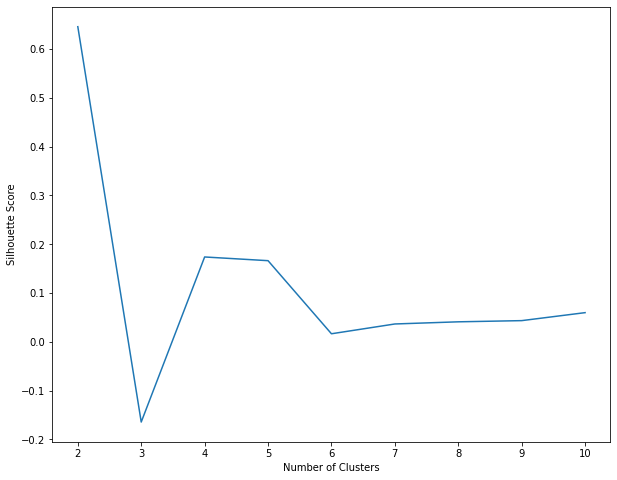

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

<div class="alert alert-info">
    
In my opinion, sometimes it’s hard to choose the optimal number of the clusters by using the elbow method. As shown in the following Figure, you can choose 2, 4 or 5. I will choose 4 in this demo.
</div>


<a id='9.2.6'></a>
### <font color=purple> 9.2.6 Pipeline Architecture</font>

In [54]:
from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans() \
          .setK(2) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(data_scale_output)

cluster = model.transform(data_scale_output)

<a id='9.2.7'></a>
### <font color=purple> 9.2.7 K-means clusters</font>

In [55]:
cluster = model.transform(data_scale_output)

In [56]:
cluster.limit(5).toPandas()

_c0                                           features  label  \
0    1  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    2.0   
1  196  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    0.0   
2  373  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    1.0   
3  379  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    0.0   
4  380  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    1.0   

                                        standardized  \
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     indexedFeatures  cluster  
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        1  
1  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        1  
2  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        1  
3  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        1  
4  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        1

<a id='10'></a>
### <font color=purple> 10.Finish
<a id='10.1'></a>
### <font color=purple> 10.1Stop MariaDB
sudo service mariadb stop

<a id='10.3'></a>
### <font color=purple> 10.2Stop HDB
stop hadoop.sh